In [1]:
import os
import pickle
import sys
from catkit import gratoms
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from time import perf_counter

In [2]:
from ase import Atoms
d = 1.1
co = Atoms('CO', positions=[(0, 0, 0), (0, 0, d)])


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
adsorbates = ['C','O']
chem_pot = [-2,-2 ]  # in eV, 1 entry for each chempot

element = []
slab_pkl = open("init_struct.pkl", "rb")
slab = pickle.load(slab_pkl)
slab = gratoms.Gratoms(slab)
surface_name = "SrTiO3(001)"
alpha = 1  # no annealing
temp = 1.0  # in terms of kbT
num_sweeps = 30 # can adjust

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites["all"]
print("adsorption coordinates are")
print(ads_positions)

sweep_size = len(ads_positions)

adsorption coordinates are
[array([0.   , 0.   , 6.965]), array([0.        , 2.55265548, 6.965     ]), array([2.55265548, 0.        , 6.965     ]), array([2.55265548, 2.55265548, 6.965     ]), array([10.21062192, 11.48694966,  6.965     ]), array([ 8.93429418, 11.48694966,  6.965     ]), array([ 8.93429418, 10.21062192,  6.965     ]), array([ 8.93429418, 12.7632774 ,  6.965     ]), array([ 7.65796644, 11.48694966,  6.965     ]), array([8.93429418, 8.93429418, 6.965     ]), array([10.21062192,  8.93429418,  6.965     ]), array([7.65796644, 8.93429418, 6.965     ]), array([16.59226062, 17.86858836,  6.965     ]), array([16.59226062, 16.59226062,  6.965     ]), array([16.59226062, 15.31593288,  6.965     ]), array([16.59226062, 14.03960514,  6.965     ]), array([ 9.35973676, 11.06150708,  6.965     ]), array([ 8.5088516 , 11.91239224,  6.965     ]), array([9.35973676, 9.35973676, 6.965     ]), array([8.5088516, 8.5088516, 6.965    ]), array([19.57035868, 17.0177032 ,  6.965     ]), array(

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF

"""if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"
    """

DEVICE = "cpu"
# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model0", "model1"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_calc = EnsembleNFF(models, device=DEVICE)

# set attributes
CUTOFF = 5
relax = True
relax_steps = 5
optimizer = "BFGS"
offset = True
offset_data = os.path.join(
    os.getcwd(),
    "offset_data.json",
)

slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=CUTOFF,
    props={"energy": 0, "energy_grad": []},
    calculator=nff_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")

max(slab.positions[:,2])
Top=[]
for i in range(len(slab_batch)):
    if max(slab.positions[:,2]) == slab.positions[i,2] :
        Top.append(i)
slab.set_surface_atoms(Top)
surf_indices = slab.get_surface_atoms()
fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
fix indices [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-04-30 12:29:55,214|INFO|there are 16 atoms in pristine slab
2024-04-30 12:29:55,215|INFO|Running with num_sweeps = 20, temp = 1.0, pot = [-2, -2], alpha = 1
2024-04-30 12:29:55,215|INFO|using slab calc <nff.io.ase.EnsembleNFF object at 0x7fbf66b2f680>
2024-04-30 12:29:55,217|INFO|adsorbate(s) is(are) ['C', 'O']
2024-04-30 12:29:55,218|INFO|In pristine slab, there are a total of 32 sites
2024-04-30 12:29:55,218|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/nff/data/sparse.py:18: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  return sp.FloatTensor(ij.t(), v, tensor.size())
/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: over

inf
temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
inf
Cu16CO
inf
Cu16COCO


2024-04-30 12:29:56,116|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,116|INFO|energy 851909168343285760.000
2024-04-30 12:29:56,117|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,117|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,117|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:56,117|INFO|saving this slab
2024-04-30 12:29:56,209|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,210|INFO|energy 857286948434214912.000
2024-04-30 12:29:56,210|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,210|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,210|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:56,210|INFO|saving this slab
2024-04-30 12:29:56,301|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,302|INFO|energy 862578073264979968.000
2024-04-30 12:29:56,302|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,

inf
Cu16COCO
inf
inf


2024-04-30 12:29:56,389|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,389|INFO|energy 862578073264979968.000
2024-04-30 12:29:56,389|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,390|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,390|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:56,390|INFO|saving this slab
2024-04-30 12:29:56,478|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,479|INFO|energy 862578073264979968.000
2024-04-30 12:29:56,479|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,479|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,479|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:56,479|INFO|saving this slab
2024-04-30 12:29:56,564|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,565|INFO|energy 862578073264979968.000
2024-04-30 12:29:56,565|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,

inf
inf
inf
Cu16COCO


2024-04-30 12:29:56,657|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,657|INFO|energy 857286948434214912.000
2024-04-30 12:29:56,657|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,658|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,658|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:56,658|INFO|saving this slab
2024-04-30 12:29:56,751|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,751|INFO|energy 857286948434214912.000
2024-04-30 12:29:56,751|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,752|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,752|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:56,752|INFO|saving this slab
2024-04-30 12:29:56,846|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,847|INFO|energy 857286948434214912.000
2024-04-30 12:29:56,847|INFO|max force 51195359257436356608.000
2024-04-30 12:29:56,

inf
Cu16COCO
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:56,947|INFO|encountered energy or force out of bounds
2024-04-30 12:29:56,947|INFO|energy 1092631571204145152.000
2024-04-30 12:29:56,947|INFO|max force 58394706309415960576.000
2024-04-30 12:29:56,948|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:56,948|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:29:56,948|INFO|saving this slab
2024-04-30 12:29:57,034|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,035|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,035|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,035|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,035|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:57,035|INFO|saving this slab
2024-04-30 12:29:57,137|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,137|INFO|energy 851932876562759680.000
2024-04-30 12:29:57,138|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:57,238|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,238|INFO|energy 857286948434214912.000
2024-04-30 12:29:57,238|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,239|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,239|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:57,239|INFO|saving this slab
2024-04-30 12:29:57,331|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,332|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,332|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,332|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,332|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:57,332|INFO|saving this slab
2024-04-30 12:29:57,426|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,426|INFO|energy 857286948434214912.000
2024-04-30 12:29:57,426|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:57,527|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,527|INFO|energy 857286948434214912.000
2024-04-30 12:29:57,528|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,528|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,528|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:57,528|INFO|saving this slab
2024-04-30 12:29:57,619|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,619|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,619|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,620|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,620|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:57,620|INFO|saving this slab
2024-04-30 12:29:57,712|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,713|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,713|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,

inf
inf
inf


2024-04-30 12:29:57,806|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,807|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,807|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,807|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,807|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:57,807|INFO|saving this slab
2024-04-30 12:29:57,899|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,899|INFO|energy 862578073264979968.000
2024-04-30 12:29:57,899|INFO|max force 51195359257436356608.000
2024-04-30 12:29:57,900|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:57,900|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:57,900|INFO|saving this slab
2024-04-30 12:29:57,999|INFO|encountered energy or force out of bounds
2024-04-30 12:29:57,999|INFO|energy 857858557041704960.000
2024-04-30 12:29:57,999|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:58,098|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,099|INFO|energy 857286948434214912.000
2024-04-30 12:29:58,099|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,099|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,099|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:58,099|INFO|saving this slab
2024-04-30 12:29:58,193|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,193|INFO|energy 862578073264979968.000
2024-04-30 12:29:58,193|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,194|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,194|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:58,194|INFO|saving this slab
2024-04-30 12:29:58,286|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,286|INFO|energy 862578073264979968.000
2024-04-30 12:29:58,287|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,

inf
inf
inf
Cu16COCO


2024-04-30 12:29:58,388|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,389|INFO|energy 59151759647558336512.000
2024-04-30 12:29:58,389|INFO|max force 819125748118981705728.000
2024-04-30 12:29:58,390|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,390|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:29:58,390|INFO|saving this slab
2024-04-30 12:29:58,497|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,498|INFO|energy 851932876562759680.000
2024-04-30 12:29:58,498|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,498|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,498|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:58,498|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:58,598|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,598|INFO|energy 851932876562759680.000
2024-04-30 12:29:58,599|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,599|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,599|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:58,599|INFO|saving this slab
2024-04-30 12:29:58,689|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,690|INFO|energy 862578073264979968.000
2024-04-30 12:29:58,690|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,690|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,690|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:58,691|INFO|saving this slab
2024-04-30 12:29:58,792|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,792|INFO|energy 851909168343285760.000
2024-04-30 12:29:58,792|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:58,889|INFO|encountered energy or force out of bounds
2024-04-30 12:29:58,889|INFO|energy 857286948434214912.000
2024-04-30 12:29:58,890|INFO|max force 51195359257436356608.000
2024-04-30 12:29:58,890|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:58,891|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:58,891|INFO|saving this slab


inf
      Step     Time          Energy         fmax
BFGS:    0 12:29:58 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:29:59 749645790867095552.000000           inf


/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/ase/optimize/optimize.py:284: RuntimeWarning: overflow encountered in square
  fmax = sqrt((forces ** 2).sum(axis=1).max())
/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/ase/optimize/optimize.py:279: RuntimeWarning: overflow encountered in square
  return (forces ** 2).sum(axis=1).max() < self.fmax ** 2
/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/numpy/core/numeric.py:925: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


BFGS:    2 12:29:59 476880492436652032.000000        0.0000


2024-04-30 12:29:59,319|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,320|INFO|energy 862578073264979968.000
2024-04-30 12:29:59,320|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,320|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,320|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:59,321|INFO|saving this slab
2024-04-30 12:29:59,321|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:29:59,321|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:29:59,322|INFO|average force error = inf
2024-04-30 12:29:59,323|INFO|In sweep 2 out of 20


inf


2024-04-30 12:29:59,415|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,415|INFO|energy 862578073264979968.000
2024-04-30 12:29:59,416|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,416|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,416|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:59,416|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:29:59,524|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,525|INFO|energy 861470727616856064.000
2024-04-30 12:29:59,525|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,525|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,525|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:59,525|INFO|saving this slab


inf


2024-04-30 12:29:59,621|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,621|INFO|energy 862578073264979968.000
2024-04-30 12:29:59,622|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,622|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,622|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:59,622|INFO|saving this slab
2024-04-30 12:29:59,721|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,722|INFO|energy 857286948434214912.000
2024-04-30 12:29:59,722|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,722|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,722|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:59,723|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:29:59,822|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,823|INFO|energy 857286948434214912.000
2024-04-30 12:29:59,823|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,823|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,823|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:29:59,823|INFO|saving this slab
2024-04-30 12:29:59,917|INFO|encountered energy or force out of bounds
2024-04-30 12:29:59,917|INFO|energy 862578073264979968.000
2024-04-30 12:29:59,917|INFO|max force 51195359257436356608.000
2024-04-30 12:29:59,918|INFO|encountered energy or forces out of bounds
2024-04-30 12:29:59,918|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:29:59,918|INFO|saving this slab
2024-04-30 12:30:00,013|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,013|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,014|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,

inf
inf
inf


2024-04-30 12:30:00,108|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,108|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,108|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,109|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,109|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:00,109|INFO|saving this slab
2024-04-30 12:30:00,204|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,204|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,204|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,205|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,205|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:00,205|INFO|saving this slab
2024-04-30 12:30:00,306|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,306|INFO|energy 857286948434214912.000
2024-04-30 12:30:00,307|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:00,404|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,404|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,404|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,404|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,405|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:00,405|INFO|saving this slab
2024-04-30 12:30:00,507|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,508|INFO|energy 824145675108220928.000
2024-04-30 12:30:00,508|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,508|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,508|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:00,509|INFO|saving this slab
2024-04-30 12:30:00,601|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,601|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,601|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,

inf
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:00,710|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,711|INFO|energy 434399177070346240.000
2024-04-30 12:30:00,711|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,711|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,712|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:00,712|INFO|saving this slab
2024-04-30 12:30:00,805|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,805|INFO|energy 862578073264979968.000
2024-04-30 12:30:00,805|INFO|max force 51195359257436356608.000
2024-04-30 12:30:00,806|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:00,806|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:00,806|INFO|saving this slab
2024-04-30 12:30:00,907|INFO|encountered energy or force out of bounds
2024-04-30 12:30:00,907|INFO|energy 535559503865708544.000
2024-04-30 12:30:00,907|INFO|max force 25597679628718178304.000
2024-04-30 12:30:00,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:01,002|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,002|INFO|energy 862578073264979968.000
2024-04-30 12:30:01,002|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,003|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,003|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:01,003|INFO|saving this slab
2024-04-30 12:30:01,096|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,096|INFO|energy 862578073264979968.000
2024-04-30 12:30:01,097|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,097|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,097|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:01,097|INFO|saving this slab
2024-04-30 12:30:01,196|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,197|INFO|energy 857286948434214912.000
2024-04-30 12:30:01,197|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:01,293|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,293|INFO|energy 862578073264979968.000
2024-04-30 12:30:01,294|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,294|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,294|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:01,294|INFO|saving this slab
2024-04-30 12:30:01,396|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,396|INFO|energy 857286948434214912.000
2024-04-30 12:30:01,396|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,397|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,397|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:01,397|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:01,500|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,500|INFO|energy 860015523977494528.000
2024-04-30 12:30:01,500|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,500|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,500|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:01,501|INFO|saving this slab
2024-04-30 12:30:01,602|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,602|INFO|energy 857286948434214912.000
2024-04-30 12:30:01,603|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,603|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,603|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:01,603|INFO|saving this slab
2024-04-30 12:30:01,695|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,695|INFO|energy 862578073264979968.000
2024-04-30 12:30:01,695|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,

inf
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:01,798|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,799|INFO|energy 535559503865708544.000
2024-04-30 12:30:01,799|INFO|max force 25597679628718178304.000
2024-04-30 12:30:01,799|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,799|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:01,799|INFO|saving this slab
2024-04-30 12:30:01,899|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,900|INFO|energy 851909168343285760.000
2024-04-30 12:30:01,900|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,900|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:01,900|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:01,900|INFO|saving this slab
2024-04-30 12:30:01,995|INFO|encountered energy or force out of bounds
2024-04-30 12:30:01,995|INFO|energy 857286948434214912.000
2024-04-30 12:30:01,995|INFO|max force 51195359257436356608.000
2024-04-30 12:30:01,

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:02,086|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,086|INFO|energy 862578073264979968.000
2024-04-30 12:30:02,087|INFO|max force 51195359257436356608.000
2024-04-30 12:30:02,087|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:02,087|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:02,087|INFO|saving this slab
2024-04-30 12:30:02,179|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,179|INFO|energy 862578073264979968.000
2024-04-30 12:30:02,179|INFO|max force 51195359257436356608.000
2024-04-30 12:30:02,180|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:02,180|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:02,180|INFO|saving this slab
2024-04-30 12:30:02,282|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,282|INFO|energy 851932876562759680.000
2024-04-30 12:30:02,282|INFO|max force 51195359257436356608.000
2024-04-30 12:30:02,

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:02,386|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,386|INFO|energy 59151759647558336512.000
2024-04-30 12:30:02,386|INFO|max force 819125748118981705728.000
2024-04-30 12:30:02,387|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:02,387|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:02,387|INFO|saving this slab
2024-04-30 12:30:02,487|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,487|INFO|energy 857286948434214912.000
2024-04-30 12:30:02,487|INFO|max force 51195359257436356608.000
2024-04-30 12:30:02,488|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:02,488|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:02,488|INFO|saving this slab


inf
Cu16COCO
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:02 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:02 749645790867095552.000000           inf
BFGS:    2 12:30:02 476880492436652032.000000        0.0000


2024-04-30 12:30:02,940|INFO|encountered energy or force out of bounds
2024-04-30 12:30:02,941|INFO|energy 862578073264979968.000
2024-04-30 12:30:02,941|INFO|max force 51195359257436356608.000
2024-04-30 12:30:02,941|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:02,942|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:02,942|INFO|saving this slab
2024-04-30 12:30:02,943|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:02,943|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:02,943|INFO|average force error = inf
2024-04-30 12:30:02,944|INFO|In sweep 3 out of 20


inf
Cu16COCO


2024-04-30 12:30:03,043|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,043|INFO|energy 851932876562759680.000
2024-04-30 12:30:03,043|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,044|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,044|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:03,044|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:03,149|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,150|INFO|energy 824145675108220928.000
2024-04-30 12:30:03,150|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,150|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,150|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:03,150|INFO|saving this slab
2024-04-30 12:30:03,239|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,239|INFO|energy 867869335534698496.000
2024-04-30 12:30:03,240|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,240|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,240|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:03,240|INFO|saving this slab


inf
inf


2024-04-30 12:30:03,326|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,327|INFO|energy 867869335534698496.000
2024-04-30 12:30:03,327|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,327|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,328|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:03,328|INFO|saving this slab


inf


2024-04-30 12:30:03,414|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,415|INFO|energy 867869335534698496.000
2024-04-30 12:30:03,415|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,415|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,415|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:03,416|INFO|saving this slab
2024-04-30 12:30:03,500|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,500|INFO|energy 867869335534698496.000
2024-04-30 12:30:03,501|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,501|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,501|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:03,502|INFO|saving this slab


inf
inf


2024-04-30 12:30:03,587|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,588|INFO|energy 867869335534698496.000
2024-04-30 12:30:03,588|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,588|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,588|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:03,589|INFO|saving this slab


inf
Cu16CO


2024-04-30 12:30:03,684|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,684|INFO|energy 862578073264979968.000
2024-04-30 12:30:03,684|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,685|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,685|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:03,685|INFO|saving this slab
2024-04-30 12:30:03,784|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,784|INFO|energy 854720275978125312.000
2024-04-30 12:30:03,784|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,784|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,785|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:03,785|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:03,881|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,882|INFO|energy 857286948434214912.000
2024-04-30 12:30:03,882|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,882|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,882|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:03,882|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:03,979|INFO|encountered energy or force out of bounds
2024-04-30 12:30:03,980|INFO|energy 857286948434214912.000
2024-04-30 12:30:03,980|INFO|max force 51195359257436356608.000
2024-04-30 12:30:03,980|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:03,981|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:03,981|INFO|saving this slab
2024-04-30 12:30:04,082|INFO|encountered energy or force out of bounds


inf
Cu16COCO


2024-04-30 12:30:04,083|INFO|energy 168434301804483379724288.000
2024-04-30 12:30:04,083|INFO|max force 4193872453304637290708992.000
2024-04-30 12:30:04,084|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,084|INFO|max_force 4193872453304637290708992.000, energy -246.758
2024-04-30 12:30:04,084|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:04,182|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,182|INFO|energy 858303034617233408.000
2024-04-30 12:30:04,182|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,183|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,183|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:04,183|INFO|saving this slab
2024-04-30 12:30:04,274|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,274|INFO|energy 862578073264979968.000
2024-04-30 12:30:04,274|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,275|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,275|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:04,275|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:04,375|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,375|INFO|energy 59151759647558336512.000
2024-04-30 12:30:04,375|INFO|max force 819125748118981705728.000
2024-04-30 12:30:04,376|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,376|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:04,376|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:04,469|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,469|INFO|energy 857286948434214912.000
2024-04-30 12:30:04,469|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,470|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,470|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:04,470|INFO|saving this slab
2024-04-30 12:30:04,571|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,571|INFO|energy 857297462514155520.000
2024-04-30 12:30:04,571|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,572|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,572|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:04,572|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:04,662|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,662|INFO|energy 862578073264979968.000
2024-04-30 12:30:04,662|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,662|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,663|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:04,663|INFO|saving this slab


inf


2024-04-30 12:30:04,750|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,750|INFO|energy 862578073264979968.000
2024-04-30 12:30:04,750|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,751|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,751|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:04,751|INFO|saving this slab
2024-04-30 12:30:04,842|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,842|INFO|energy 862578073264979968.000
2024-04-30 12:30:04,842|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,843|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,843|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:04,843|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:04,938|INFO|encountered energy or force out of bounds
2024-04-30 12:30:04,938|INFO|energy 857286948434214912.000
2024-04-30 12:30:04,938|INFO|max force 51195359257436356608.000
2024-04-30 12:30:04,938|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:04,939|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:04,939|INFO|saving this slab


inf


2024-04-30 12:30:05,029|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,029|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,030|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,030|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,030|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,030|INFO|saving this slab
2024-04-30 12:30:05,135|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,135|INFO|energy 535559503865708544.000
2024-04-30 12:30:05,135|INFO|max force 25597679628718178304.000
2024-04-30 12:30:05,136|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,136|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:05,137|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:05,230|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,230|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,230|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,231|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,231|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,232|INFO|saving this slab
2024-04-30 12:30:05,323|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,323|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,323|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,324|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,324|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,324|INFO|saving this slab
2024-04-30 12:30:05,424|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,425|INFO|energy 168434301804483379724288.000
2024-04-30 12:30:05,425|INFO|max force 4193872453304637290708992.000
2024-04-3

inf
inf
Cu16COCO
inf


2024-04-30 12:30:05,516|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,517|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,517|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,517|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,517|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,518|INFO|saving this slab
2024-04-30 12:30:05,607|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,607|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,608|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,608|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,608|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,608|INFO|saving this slab
2024-04-30 12:30:05,701|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,701|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,701|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,

inf
inf
inf


2024-04-30 12:30:05,793|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,794|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,794|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,794|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,795|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,795|INFO|saving this slab
2024-04-30 12:30:05,888|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,888|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,888|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,889|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:05,889|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:05,889|INFO|saving this slab
2024-04-30 12:30:05,981|INFO|encountered energy or force out of bounds
2024-04-30 12:30:05,981|INFO|energy 862578073264979968.000
2024-04-30 12:30:05,982|INFO|max force 51195359257436356608.000
2024-04-30 12:30:05,

inf
inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:06 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:06 749645790867095552.000000           inf
BFGS:    2 12:30:06 476880492436652032.000000        0.0000


2024-04-30 12:30:06,372|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,373|INFO|energy 862578073264979968.000
2024-04-30 12:30:06,373|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,373|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,373|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:06,373|INFO|saving this slab
2024-04-30 12:30:06,374|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:06,374|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:06,374|INFO|average force error = inf
2024-04-30 12:30:06,375|INFO|In sweep 4 out of 20


inf
Cu16COCO


2024-04-30 12:30:06,474|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,474|INFO|energy 857286948434214912.000
2024-04-30 12:30:06,475|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,475|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,475|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:06,475|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:06,578|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,578|INFO|energy 59151759647558336512.000
2024-04-30 12:30:06,579|INFO|max force 819125748118981705728.000
2024-04-30 12:30:06,579|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,579|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:06,579|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:06,683|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,683|INFO|energy 857297462514155520.000
2024-04-30 12:30:06,683|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,684|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,684|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:06,684|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:06,786|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,787|INFO|energy 855028414111809536.000
2024-04-30 12:30:06,787|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,787|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,787|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:06,788|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:06,889|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,889|INFO|energy 857286948434214912.000
2024-04-30 12:30:06,890|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,890|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,890|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:06,890|INFO|saving this slab
2024-04-30 12:30:06,980|INFO|encountered energy or force out of bounds
2024-04-30 12:30:06,981|INFO|energy 862578073264979968.000
2024-04-30 12:30:06,981|INFO|max force 51195359257436356608.000
2024-04-30 12:30:06,981|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:06,981|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:06,981|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:07,077|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,078|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,078|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,079|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,079|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,079|INFO|saving this slab


inf


2024-04-30 12:30:07,175|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,175|INFO|energy 862578073264979968.000
2024-04-30 12:30:07,175|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,176|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,176|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:07,176|INFO|saving this slab
2024-04-30 12:30:07,273|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,274|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,274|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,274|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,275|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,275|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:07,373|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,374|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,374|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,374|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,374|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,374|INFO|saving this slab


inf


2024-04-30 12:30:07,473|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,473|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,473|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,473|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,474|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,474|INFO|saving this slab
2024-04-30 12:30:07,570|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,571|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,571|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,571|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,571|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,571|INFO|saving this slab


Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:07,662|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,662|INFO|energy 862578073264979968.000
2024-04-30 12:30:07,662|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,663|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,663|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:07,663|INFO|saving this slab
2024-04-30 12:30:07,758|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,759|INFO|energy 857286948434214912.000
2024-04-30 12:30:07,759|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,760|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,760|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:07,760|INFO|saving this slab
2024-04-30 12:30:07,860|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,861|INFO|energy 168434301804483379724288.000
2024-04-30 12:30:07,861|INFO|max force 4193872453304637290708992.000
2024-04-3

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:07,950|INFO|encountered energy or force out of bounds
2024-04-30 12:30:07,951|INFO|energy 862578073264979968.000
2024-04-30 12:30:07,951|INFO|max force 51195359257436356608.000
2024-04-30 12:30:07,951|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:07,952|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:07,952|INFO|saving this slab
2024-04-30 12:30:08,053|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,053|INFO|energy 59151759647558336512.000
2024-04-30 12:30:08,054|INFO|max force 819125748118981705728.000
2024-04-30 12:30:08,054|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,054|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:08,054|INFO|saving this slab
2024-04-30 12:30:08,147|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,147|INFO|energy 862578073264979968.000
2024-04-30 12:30:08,147|INFO|max force 51195359257436356608.000
2024-04-30 12:30

inf
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:08,246|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,246|INFO|energy 857286948434214912.000
2024-04-30 12:30:08,247|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,247|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,247|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:08,247|INFO|saving this slab
2024-04-30 12:30:08,342|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,343|INFO|energy 857286948434214912.000
2024-04-30 12:30:08,343|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,343|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,343|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:08,343|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:08,449|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,450|INFO|energy 434399177070346240.000
2024-04-30 12:30:08,450|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,450|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,450|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:08,451|INFO|saving this slab
2024-04-30 12:30:08,543|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,543|INFO|energy 862578073264979968.000
2024-04-30 12:30:08,543|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,544|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,544|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:08,544|INFO|saving this slab
2024-04-30 12:30:08,635|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,636|INFO|energy 862578073264979968.000
2024-04-30 12:30:08,636|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,

inf
inf
inf
Cu16COCO


2024-04-30 12:30:08,741|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,742|INFO|energy 851909168343285760.000
2024-04-30 12:30:08,742|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,742|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,743|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:08,743|INFO|saving this slab
2024-04-30 12:30:08,840|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,840|INFO|energy 857286948434214912.000
2024-04-30 12:30:08,840|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,840|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:08,841|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:08,841|INFO|saving this slab
2024-04-30 12:30:08,929|INFO|encountered energy or force out of bounds
2024-04-30 12:30:08,929|INFO|energy 867869335534698496.000
2024-04-30 12:30:08,930|INFO|max force 51195359257436356608.000
2024-04-30 12:30:08,

inf
Cu16COCO
inf
inf


2024-04-30 12:30:09,019|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,019|INFO|energy 867869335534698496.000
2024-04-30 12:30:09,020|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,020|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:09,020|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:09,020|INFO|saving this slab
2024-04-30 12:30:09,112|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,112|INFO|energy 862578073264979968.000
2024-04-30 12:30:09,113|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,113|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:09,113|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:09,113|INFO|saving this slab
2024-04-30 12:30:09,208|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,208|INFO|energy 857286948434214912.000
2024-04-30 12:30:09,209|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,

inf
Cu16CO
inf
Cu16COCO
inf


2024-04-30 12:30:09,300|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,300|INFO|energy 862578073264979968.000
2024-04-30 12:30:09,300|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,301|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:09,301|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:09,301|INFO|saving this slab
2024-04-30 12:30:09,398|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,398|INFO|energy 857286948434214912.000
2024-04-30 12:30:09,398|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,399|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:09,399|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:09,399|INFO|saving this slab
2024-04-30 12:30:09,492|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,493|INFO|energy 857286948434214912.000
2024-04-30 12:30:09,493|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,

inf
Cu16COCO
inf
Cu16COCO
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:09 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:09 749645790867095552.000000           inf
BFGS:    2 12:30:09 476880492436652032.000000        0.0000


2024-04-30 12:30:09,928|INFO|encountered energy or force out of bounds
2024-04-30 12:30:09,928|INFO|energy 862578073264979968.000
2024-04-30 12:30:09,928|INFO|max force 51195359257436356608.000
2024-04-30 12:30:09,929|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:09,929|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:09,929|INFO|saving this slab
2024-04-30 12:30:09,930|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:09,930|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:09,930|INFO|average force error = inf
2024-04-30 12:30:09,931|INFO|In sweep 5 out of 20


inf


2024-04-30 12:30:10,032|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,032|INFO|energy 862578073264979968.000
2024-04-30 12:30:10,032|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,033|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,033|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:10,033|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:10,155|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,156|INFO|energy 855028414111809536.000
2024-04-30 12:30:10,156|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,156|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,156|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:10,157|INFO|saving this slab


inf


2024-04-30 12:30:10,266|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,266|INFO|energy 862578073264979968.000
2024-04-30 12:30:10,266|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,267|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,267|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:10,267|INFO|saving this slab


inf


2024-04-30 12:30:10,373|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,373|INFO|energy 862578073264979968.000
2024-04-30 12:30:10,374|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,374|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,374|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:10,374|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:10,499|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,499|INFO|energy 839530385401446400.000
2024-04-30 12:30:10,499|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,500|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,500|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:10,501|INFO|saving this slab


inf


2024-04-30 12:30:10,613|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,613|INFO|energy 862578073264979968.000
2024-04-30 12:30:10,613|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,614|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,614|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:10,614|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:10,726|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,726|INFO|energy 857286948434214912.000
2024-04-30 12:30:10,727|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,727|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,727|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:10,727|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:10,849|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,850|INFO|energy 839530385401446400.000
2024-04-30 12:30:10,850|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,850|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,851|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:10,851|INFO|saving this slab


inf


2024-04-30 12:30:10,960|INFO|encountered energy or force out of bounds
2024-04-30 12:30:10,961|INFO|energy 862578073264979968.000
2024-04-30 12:30:10,961|INFO|max force 51195359257436356608.000
2024-04-30 12:30:10,961|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:10,962|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:10,962|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:11,079|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,079|INFO|energy 857286948434214912.000
2024-04-30 12:30:11,079|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,080|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,080|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:11,080|INFO|saving this slab


inf


2024-04-30 12:30:11,190|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,191|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,191|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,192|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,192|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,192|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:11,312|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,312|INFO|energy 857964659913785344.000
2024-04-30 12:30:11,312|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,313|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,313|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:11,313|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:11,410|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,410|INFO|energy 857286948434214912.000
2024-04-30 12:30:11,410|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,411|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,411|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:11,411|INFO|saving this slab
2024-04-30 12:30:11,493|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,494|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,494|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,494|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,494|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,494|INFO|saving this slab


inf
inf


2024-04-30 12:30:11,584|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,585|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,585|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,586|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,586|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,586|INFO|saving this slab


inf


2024-04-30 12:30:11,671|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,671|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,672|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,672|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,672|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,673|INFO|saving this slab
2024-04-30 12:30:11,761|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,762|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,762|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,763|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,763|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,763|INFO|saving this slab


inf
inf


2024-04-30 12:30:11,850|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,850|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,851|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,851|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,851|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,851|INFO|saving this slab


inf


2024-04-30 12:30:11,941|INFO|encountered energy or force out of bounds
2024-04-30 12:30:11,941|INFO|energy 862578073264979968.000
2024-04-30 12:30:11,941|INFO|max force 51195359257436356608.000
2024-04-30 12:30:11,942|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:11,942|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:11,942|INFO|saving this slab
2024-04-30 12:30:12,029|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,029|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,029|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,030|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,030|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,030|INFO|saving this slab


inf
inf


2024-04-30 12:30:12,119|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,119|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,120|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,120|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,120|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,120|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:12,218|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,219|INFO|energy 855245773816725504.000
2024-04-30 12:30:12,219|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,219|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,219|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:12,219|INFO|saving this slab
2024-04-30 12:30:12,311|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,311|INFO|energy 857286948434214912.000
2024-04-30 12:30:12,311|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,312|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,312|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:12,312|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:12,397|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,397|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,397|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,397|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,398|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,398|INFO|saving this slab


inf


2024-04-30 12:30:12,480|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,480|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,480|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,480|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,481|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,481|INFO|saving this slab
2024-04-30 12:30:12,573|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,574|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,574|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,574|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,574|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,575|INFO|saving this slab


inf
inf


2024-04-30 12:30:12,664|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,665|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,665|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,665|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,665|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,666|INFO|saving this slab


inf


2024-04-30 12:30:12,752|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,753|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,753|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,753|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,753|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,753|INFO|saving this slab
2024-04-30 12:30:12,845|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,845|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,845|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,845|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,846|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,846|INFO|saving this slab


inf
inf


2024-04-30 12:30:12,934|INFO|encountered energy or force out of bounds
2024-04-30 12:30:12,935|INFO|energy 862578073264979968.000
2024-04-30 12:30:12,935|INFO|max force 51195359257436356608.000
2024-04-30 12:30:12,935|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:12,935|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:12,935|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:13,030|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,030|INFO|energy 857286948434214912.000
2024-04-30 12:30:13,031|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,031|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,031|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:13,031|INFO|saving this slab
2024-04-30 12:30:13,125|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,125|INFO|energy 857286948434214912.000
2024-04-30 12:30:13,126|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,126|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,126|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:13,126|INFO|saving this slab


inf
Cu16COCO
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:13 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:13 749645790867095552.000000           inf
BFGS:    2 12:30:13 476880492436652032.000000        0.0000


2024-04-30 12:30:13,580|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,581|INFO|energy 862578073264979968.000
2024-04-30 12:30:13,581|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,581|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,581|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:13,581|INFO|saving this slab
2024-04-30 12:30:13,582|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:13,582|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:13,582|INFO|average force error = inf
2024-04-30 12:30:13,584|INFO|In sweep 6 out of 20


inf
Cu16COCO


2024-04-30 12:30:13,679|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,679|INFO|energy 857286948434214912.000
2024-04-30 12:30:13,679|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,680|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,680|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:13,680|INFO|saving this slab
2024-04-30 12:30:13,779|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,779|INFO|energy 857286948434214912.000
2024-04-30 12:30:13,779|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,780|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,780|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:13,780|INFO|saving this slab


inf
inf
Cu16COCOCO


2024-04-30 12:30:13,884|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,884|INFO|energy 851995548725542912.000
2024-04-30 12:30:13,884|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,884|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,885|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:13,885|INFO|saving this slab
2024-04-30 12:30:13,978|INFO|encountered energy or force out of bounds
2024-04-30 12:30:13,979|INFO|energy 857286948434214912.000
2024-04-30 12:30:13,979|INFO|max force 51195359257436356608.000
2024-04-30 12:30:13,979|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:13,979|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:13,979|INFO|saving this slab
2024-04-30 12:30:14,086|INFO|encountered energy or force out of bounds


inf
inf
Cu16COCOCO


2024-04-30 12:30:14,086|INFO|energy 849737289281044480.000
2024-04-30 12:30:14,086|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,087|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,087|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:14,087|INFO|saving this slab
2024-04-30 12:30:14,197|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,197|INFO|energy 846641751731994624.000
2024-04-30 12:30:14,197|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,198|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,198|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:14,198|INFO|saving this slab


inf
Cu16COCOCO
inf


2024-04-30 12:30:14,296|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,296|INFO|energy 857286948434214912.000
2024-04-30 12:30:14,296|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,297|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,297|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:14,297|INFO|saving this slab
2024-04-30 12:30:14,386|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,387|INFO|energy 862578073264979968.000
2024-04-30 12:30:14,387|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,387|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,387|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:14,388|INFO|saving this slab
2024-04-30 12:30:14,485|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,485|INFO|energy 855028414111809536.000
2024-04-30 12:30:14,485|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:14,580|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,581|INFO|energy 862578073264979968.000
2024-04-30 12:30:14,581|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,582|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,582|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:14,582|INFO|saving this slab
2024-04-30 12:30:14,678|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,678|INFO|energy 862578073264979968.000
2024-04-30 12:30:14,679|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,679|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,679|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:14,680|INFO|saving this slab
2024-04-30 12:30:14,781|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,782|INFO|energy 857286948434214912.000


inf
inf
Cu16COCO


2024-04-30 12:30:14,782|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,783|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,783|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:14,783|INFO|saving this slab
2024-04-30 12:30:14,882|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,883|INFO|energy 857286948434214912.000
2024-04-30 12:30:14,883|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,884|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,884|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:14,884|INFO|saving this slab
2024-04-30 12:30:14,980|INFO|encountered energy or force out of bounds
2024-04-30 12:30:14,981|INFO|energy 857286948434214912.000
2024-04-30 12:30:14,981|INFO|max force 51195359257436356608.000
2024-04-30 12:30:14,981|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:14,981|INFO|max_force 51195359257436356608.000, energy -246.7

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:15,074|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,074|INFO|energy 862578073264979968.000
2024-04-30 12:30:15,075|INFO|max force 51195359257436356608.000
2024-04-30 12:30:15,075|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,075|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:15,075|INFO|saving this slab
2024-04-30 12:30:15,172|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,173|INFO|energy 168432266177451808260096.000
2024-04-30 12:30:15,173|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:15,173|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,174|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:15,174|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:15,278|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,278|INFO|energy 434399177070346240.000
2024-04-30 12:30:15,278|INFO|max force 51195359257436356608.000
2024-04-30 12:30:15,279|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,279|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:15,280|INFO|saving this slab
2024-04-30 12:30:15,376|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,377|INFO|energy 857286948434214912.000
2024-04-30 12:30:15,377|INFO|max force 51195359257436356608.000
2024-04-30 12:30:15,378|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,378|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:15,378|INFO|saving this slab
2024-04-30 12:30:15,463|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,463|INFO|energy 867869335534698496.000
2024-04-30 12:30:15,463|INFO|max force 51195359257436356608.000
2024-04-30 12:30:15,

inf
Cu16COCO
inf
inf
Cu16CO


2024-04-30 12:30:15,562|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,562|INFO|energy 439690267541372928.000
2024-04-30 12:30:15,563|INFO|max force 25597679628718178304.000
2024-04-30 12:30:15,563|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,563|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:15,563|INFO|saving this slab
2024-04-30 12:30:15,676|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,676|INFO|energy 61081942551953408.000
2024-04-30 12:30:15,676|INFO|max force 12748843921132486656.000
2024-04-30 12:30:15,677|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,677|INFO|max_force 12748843921132486656.000, energy -246.758
2024-04-30 12:30:15,677|INFO|saving this slab


inf
Cu16COCO
1.4916097063077806e+18
Cu16COCO


2024-04-30 12:30:15,781|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,781|INFO|energy 434398661674270720.000
2024-04-30 12:30:15,781|INFO|max force 25597679628718178304.000
2024-04-30 12:30:15,782|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,782|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:15,782|INFO|saving this slab
2024-04-30 12:30:15,879|INFO|encountered energy or force out of bounds
2024-04-30 12:30:15,880|INFO|energy 439690267541372928.000
2024-04-30 12:30:15,880|INFO|max force 25597679628718178304.000
2024-04-30 12:30:15,880|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,880|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:15,880|INFO|saving this slab
2024-04-30 12:30:15,982|INFO|encountered energy or force out of bounds


inf
inf
Cu16COCO


2024-04-30 12:30:15,983|INFO|energy 434398661674270720.000
2024-04-30 12:30:15,983|INFO|max force 25597679628718178304.000
2024-04-30 12:30:15,983|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:15,983|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:15,983|INFO|saving this slab
2024-04-30 12:30:16,083|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,083|INFO|energy 439690267541372928.000
2024-04-30 12:30:16,083|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,084|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,084|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:16,084|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:16,185|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,185|INFO|energy 434398661674270720.000
2024-04-30 12:30:16,185|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,186|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,186|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:16,186|INFO|saving this slab
2024-04-30 12:30:16,288|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,288|INFO|energy 434398661674270720.000
2024-04-30 12:30:16,289|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,289|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,289|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:16,289|INFO|saving this slab
2024-04-30 12:30:16,383|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,383|INFO|energy 434398661674270720.000
2024-04-30 12:30:16,384|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:16,480|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,480|INFO|energy 439690267541372928.000
2024-04-30 12:30:16,480|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,481|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,481|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:16,481|INFO|saving this slab
2024-04-30 12:30:16,579|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,580|INFO|energy 434398661674270720.000
2024-04-30 12:30:16,580|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,580|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,580|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:16,581|INFO|saving this slab
2024-04-30 12:30:16,678|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,679|INFO|energy 439690267541372928.000
2024-04-30 12:30:16,679|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,

inf
Cu16COCO
inf
inf


2024-04-30 12:30:16,775|INFO|encountered energy or force out of bounds
2024-04-30 12:30:16,775|INFO|energy 439690267541372928.000
2024-04-30 12:30:16,776|INFO|max force 25597679628718178304.000
2024-04-30 12:30:16,776|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:16,776|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:16,776|INFO|saving this slab


inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:16 439690267541372928.000000  3199717604609709568.0000


/home/spanja/miniconda3/envs/ase_latest/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


BFGS:    1 12:30:16 -14730502523966193664.000000           inf
BFGS:    2 12:30:16 476880492436652032.000000        0.0000


2024-04-30 12:30:17,166|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,166|INFO|energy 439690267541372928.000
2024-04-30 12:30:17,166|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,167|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,167|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:17,167|INFO|saving this slab
2024-04-30 12:30:17,168|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:17,168|INFO|optim structure has Free Energy = 140.000+/-433701914899644416.000
2024-04-30 12:30:17,168|INFO|average force error = inf
2024-04-30 12:30:17,169|INFO|In sweep 7 out of 20


inf
Cu16COCO


2024-04-30 12:30:17,254|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,254|INFO|energy 434398661674270720.000
2024-04-30 12:30:17,254|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,255|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,255|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:17,255|INFO|saving this slab
2024-04-30 12:30:17,327|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,327|INFO|energy 434398661674270720.000
2024-04-30 12:30:17,328|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,328|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,329|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:17,329|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:17,402|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,402|INFO|energy 439690267541372928.000
2024-04-30 12:30:17,402|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,403|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,403|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:17,403|INFO|saving this slab


inf


2024-04-30 12:30:17,476|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,477|INFO|energy 439690267541372928.000
2024-04-30 12:30:17,477|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,477|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,478|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:17,478|INFO|saving this slab
2024-04-30 12:30:17,577|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,578|INFO|energy 439690267541372928.000
2024-04-30 12:30:17,578|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,578|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,578|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:17,579|INFO|saving this slab


inf
inf


2024-04-30 12:30:17,677|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,677|INFO|energy 439690267541372928.000
2024-04-30 12:30:17,677|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,678|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,678|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:17,678|INFO|saving this slab
2024-04-30 12:30:17,780|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,780|INFO|energy 434398661674270720.000
2024-04-30 12:30:17,780|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,781|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,781|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:17,781|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:17,883|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,883|INFO|energy 434398661674270720.000
2024-04-30 12:30:17,883|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,883|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,884|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:17,884|INFO|saving this slab
2024-04-30 12:30:17,982|INFO|encountered energy or force out of bounds
2024-04-30 12:30:17,983|INFO|energy 434398661674270720.000
2024-04-30 12:30:17,983|INFO|max force 25597679628718178304.000
2024-04-30 12:30:17,983|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:17,983|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:17,983|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:18,090|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,090|INFO|energy 61081942551953408.000
2024-04-30 12:30:18,091|INFO|max force 12748843921132486656.000
2024-04-30 12:30:18,091|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,092|INFO|max_force 12748843921132486656.000, energy -246.758
2024-04-30 12:30:18,092|INFO|saving this slab
2024-04-30 12:30:18,189|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,189|INFO|energy 439690267541372928.000
2024-04-30 12:30:18,189|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,190|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,190|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:18,190|INFO|saving this slab
2024-04-30 12:30:18,282|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,283|INFO|energy 439690267541372928.000
2024-04-30 12:30:18,283|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,2

1.4916097063077806e+18
inf
inf


2024-04-30 12:30:18,378|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,379|INFO|energy 439690267541372928.000
2024-04-30 12:30:18,379|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,379|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,379|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:18,380|INFO|saving this slab
2024-04-30 12:30:18,485|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,485|INFO|energy 434398661674270720.000
2024-04-30 12:30:18,485|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,486|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,486|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:18,486|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:18,585|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,585|INFO|energy 439690267541372928.000
2024-04-30 12:30:18,585|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,586|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,586|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:18,586|INFO|saving this slab
2024-04-30 12:30:18,686|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,687|INFO|energy 439690267541372928.000
2024-04-30 12:30:18,687|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,687|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,687|INFO|max_force 25597679628718178304.000, energy -257.512
2024-04-30 12:30:18,688|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:18,788|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,788|INFO|energy 434398661674270720.000
2024-04-30 12:30:18,788|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,789|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,789|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:18,789|INFO|saving this slab
2024-04-30 12:30:18,892|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,892|INFO|energy 434398661674270720.000
2024-04-30 12:30:18,892|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,892|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,893|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:18,893|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:18,992|INFO|encountered energy or force out of bounds
2024-04-30 12:30:18,992|INFO|energy 434398661674270720.000
2024-04-30 12:30:18,992|INFO|max force 25597679628718178304.000
2024-04-30 12:30:18,993|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:18,993|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:18,993|INFO|saving this slab
2024-04-30 12:30:19,076|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,076|INFO|energy 867869335534698496.000
2024-04-30 12:30:19,076|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,077|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,077|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:19,077|INFO|saving this slab
2024-04-30 12:30:19,165|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,165|INFO|energy 867869335534698496.000
2024-04-30 12:30:19,165|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,

inf
inf
inf


2024-04-30 12:30:19,254|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,254|INFO|energy 867869335534698496.000
2024-04-30 12:30:19,254|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,255|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,255|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:19,255|INFO|saving this slab
2024-04-30 12:30:19,342|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,342|INFO|energy 867869335534698496.000
2024-04-30 12:30:19,343|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,343|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,343|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:19,343|INFO|saving this slab
2024-04-30 12:30:19,427|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,427|INFO|energy 867869335534698496.000
2024-04-30 12:30:19,428|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,

inf
inf
inf
Cu16CO


2024-04-30 12:30:19,487|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,488|INFO|energy 862578073264979968.000
2024-04-30 12:30:19,488|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,488|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,488|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:19,489|INFO|saving this slab
2024-04-30 12:30:19,585|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,585|INFO|energy 857286948434214912.000
2024-04-30 12:30:19,586|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,586|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,586|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:19,586|INFO|saving this slab
2024-04-30 12:30:19,675|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,675|INFO|energy 862578073264979968.000
2024-04-30 12:30:19,675|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,

inf
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:19,772|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,772|INFO|energy 857286948434214912.000
2024-04-30 12:30:19,772|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,773|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,773|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:19,773|INFO|saving this slab
2024-04-30 12:30:19,856|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,856|INFO|energy 862578073264979968.000
2024-04-30 12:30:19,857|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,857|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:19,857|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:19,857|INFO|saving this slab
2024-04-30 12:30:19,937|INFO|encountered energy or force out of bounds
2024-04-30 12:30:19,938|INFO|energy 862578073264979968.000
2024-04-30 12:30:19,938|INFO|max force 51195359257436356608.000
2024-04-30 12:30:19,

inf
inf
inf


2024-04-30 12:30:20,032|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,032|INFO|energy 862578073264979968.000
2024-04-30 12:30:20,032|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,033|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,033|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:20,033|INFO|saving this slab
2024-04-30 12:30:20,126|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,126|INFO|energy 862578073264979968.000
2024-04-30 12:30:20,126|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,127|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,127|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:20,127|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:20 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:20 749645790867095552.000000           inf
BFGS:    2 12:30:20 476880492436652032.000000        0.0000


2024-04-30 12:30:20,589|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,590|INFO|energy 862578073264979968.000
2024-04-30 12:30:20,590|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,590|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,591|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:20,591|INFO|saving this slab
2024-04-30 12:30:20,591|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:20,592|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:20,592|INFO|average force error = inf
2024-04-30 12:30:20,593|INFO|In sweep 8 out of 20


inf
Cu16COCO


2024-04-30 12:30:20,698|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,699|INFO|energy 857297462514155520.000
2024-04-30 12:30:20,699|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,699|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,700|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:20,700|INFO|saving this slab


inf


2024-04-30 12:30:20,793|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,794|INFO|energy 862578073264979968.000
2024-04-30 12:30:20,794|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,794|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,794|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:20,794|INFO|saving this slab
2024-04-30 12:30:20,895|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,895|INFO|energy 857286948434214912.000
2024-04-30 12:30:20,895|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,896|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,896|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:20,896|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:20,998|INFO|encountered energy or force out of bounds
2024-04-30 12:30:20,998|INFO|energy 857286948434214912.000
2024-04-30 12:30:20,998|INFO|max force 51195359257436356608.000
2024-04-30 12:30:20,998|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:20,999|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:20,999|INFO|saving this slab
2024-04-30 12:30:21,094|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,094|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,094|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,095|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,095|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,095|INFO|saving this slab
2024-04-30 12:30:21,187|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,188|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,188|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,

inf
inf
inf


2024-04-30 12:30:21,280|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,280|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,280|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,280|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,281|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,281|INFO|saving this slab
2024-04-30 12:30:21,374|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,374|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,374|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,374|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,375|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,375|INFO|saving this slab
2024-04-30 12:30:21,477|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,477|INFO|energy 860015523977494528.000
2024-04-30 12:30:21,477|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:21,572|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,572|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,572|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,572|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,573|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,573|INFO|saving this slab
2024-04-30 12:30:21,666|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,666|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,666|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,667|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,667|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,667|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:21,775|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,776|INFO|energy 1092631571204145152.000
2024-04-30 12:30:21,776|INFO|max force 58394706309415960576.000
2024-04-30 12:30:21,776|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,776|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:30:21,776|INFO|saving this slab
2024-04-30 12:30:21,868|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,868|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,868|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21,868|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:21,869|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:21,869|INFO|saving this slab
2024-04-30 12:30:21,959|INFO|encountered energy or force out of bounds
2024-04-30 12:30:21,960|INFO|energy 862578073264979968.000
2024-04-30 12:30:21,960|INFO|max force 51195359257436356608.000
2024-04-30 12:30:21

inf
inf
inf
Cu16COCO


2024-04-30 12:30:22,062|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,062|INFO|energy 857286948434214912.000
2024-04-30 12:30:22,062|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,063|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,063|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:22,063|INFO|saving this slab
2024-04-30 12:30:22,156|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,156|INFO|energy 862578073264979968.000
2024-04-30 12:30:22,156|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,157|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,157|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:22,157|INFO|saving this slab
2024-04-30 12:30:22,260|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,260|INFO|energy 857858557041704960.000
2024-04-30 12:30:22,261|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,

inf
inf
Cu16COCO
inf


2024-04-30 12:30:22,355|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,355|INFO|energy 862578073264979968.000
2024-04-30 12:30:22,355|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,356|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,356|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:22,356|INFO|saving this slab
2024-04-30 12:30:22,456|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,457|INFO|energy 857286948434214912.000
2024-04-30 12:30:22,457|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,457|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,457|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:22,458|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:22,560|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,560|INFO|energy 824145675108220928.000
2024-04-30 12:30:22,560|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,561|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,561|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:22,561|INFO|saving this slab
2024-04-30 12:30:22,655|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,656|INFO|energy 862578073264979968.000
2024-04-30 12:30:22,656|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,656|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,656|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:22,656|INFO|saving this slab
2024-04-30 12:30:22,757|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,757|INFO|energy 857286948434214912.000
2024-04-30 12:30:22,757|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,

inf
inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:22,860|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,860|INFO|energy 857286948434214912.000
2024-04-30 12:30:22,860|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,860|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,861|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:22,861|INFO|saving this slab
2024-04-30 12:30:22,962|INFO|encountered energy or force out of bounds
2024-04-30 12:30:22,962|INFO|energy 857286948434214912.000
2024-04-30 12:30:22,963|INFO|max force 51195359257436356608.000
2024-04-30 12:30:22,963|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:22,963|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:22,963|INFO|saving this slab
2024-04-30 12:30:23,058|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,059|INFO|energy 862578073264979968.000
2024-04-30 12:30:23,059|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,

inf
Cu16COCO
inf
inf


2024-04-30 12:30:23,148|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,148|INFO|energy 862578073264979968.000
2024-04-30 12:30:23,148|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,149|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,149|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:23,149|INFO|saving this slab
2024-04-30 12:30:23,254|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,254|INFO|energy 855293258975150080.000
2024-04-30 12:30:23,255|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,255|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,255|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:23,255|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:23,360|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,360|INFO|energy 860015523977494528.000
2024-04-30 12:30:23,360|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,361|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,361|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:23,361|INFO|saving this slab
2024-04-30 12:30:23,456|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,456|INFO|energy 862578073264979968.000
2024-04-30 12:30:23,456|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,457|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,457|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:23,457|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:23,564|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,564|INFO|energy 434400173502758912.000
2024-04-30 12:30:23,565|INFO|max force 7599310899257540608.000
2024-04-30 12:30:23,565|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,565|INFO|max_force 7599310899257540608.000, energy -246.758
2024-04-30 12:30:23,565|INFO|saving this slab
2024-04-30 12:30:23,659|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,660|INFO|energy 862578073264979968.000
2024-04-30 12:30:23,660|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,660|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:23,660|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:23,661|INFO|saving this slab
2024-04-30 12:30:23,751|INFO|encountered energy or force out of bounds
2024-04-30 12:30:23,752|INFO|energy 862578073264979968.000
2024-04-30 12:30:23,752|INFO|max force 51195359257436356608.000
2024-04-30 12:30:23,75

9.706700993189642e+17
inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:23 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:23 749645790867095552.000000           inf
BFGS:    2 12:30:23 476880492436652032.000000        0.0000


2024-04-30 12:30:24,140|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,141|INFO|energy 862578073264979968.000
2024-04-30 12:30:24,141|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,142|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,142|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:24,143|INFO|saving this slab
2024-04-30 12:30:24,143|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:24,144|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:24,144|INFO|average force error = inf
2024-04-30 12:30:24,145|INFO|In sweep 9 out of 20


inf
Cu16COCO


2024-04-30 12:30:24,249|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,249|INFO|energy 857858557041704960.000
2024-04-30 12:30:24,250|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,250|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,251|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:24,251|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:24,355|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,356|INFO|energy 824145675108220928.000
2024-04-30 12:30:24,356|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,356|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,356|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:24,357|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:24,461|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,462|INFO|energy 59151759647558336512.000
2024-04-30 12:30:24,462|INFO|max force 819125748118981705728.000
2024-04-30 12:30:24,462|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,462|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:24,462|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:24,567|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,567|INFO|energy 851932876562759680.000
2024-04-30 12:30:24,568|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,568|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,568|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:24,568|INFO|saving this slab


inf


2024-04-30 12:30:24,663|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,663|INFO|energy 862578073264979968.000
2024-04-30 12:30:24,664|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,664|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,664|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:24,664|INFO|saving this slab
2024-04-30 12:30:24,768|INFO|encountered energy or force out of bounds


inf
Cu16COCO


2024-04-30 12:30:24,768|INFO|energy 857297462514155520.000
2024-04-30 12:30:24,768|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,769|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,769|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:24,769|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:24,869|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,870|INFO|energy 857286948434214912.000
2024-04-30 12:30:24,870|INFO|max force 51195359257436356608.000
2024-04-30 12:30:24,870|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,870|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:24,870|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:24,979|INFO|encountered energy or force out of bounds
2024-04-30 12:30:24,980|INFO|energy 1092631571204145152.000
2024-04-30 12:30:24,980|INFO|max force 58394706309415960576.000
2024-04-30 12:30:24,980|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:24,981|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:30:24,981|INFO|saving this slab


inf


2024-04-30 12:30:25,076|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,076|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,077|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,077|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,077|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,078|INFO|saving this slab
2024-04-30 12:30:25,171|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,172|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,172|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,172|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,173|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,173|INFO|saving this slab


inf
inf


2024-04-30 12:30:25,267|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,267|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,267|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,268|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,268|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,268|INFO|saving this slab


inf


2024-04-30 12:30:25,361|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,362|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,362|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,362|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,362|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,362|INFO|saving this slab
2024-04-30 12:30:25,455|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,456|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,456|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,456|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,456|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,456|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:25,559|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,559|INFO|energy 857858557041704960.000
2024-04-30 12:30:25,560|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,560|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,560|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:25,560|INFO|saving this slab


inf


2024-04-30 12:30:25,654|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,655|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,655|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,655|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,655|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,655|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:25,766|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,766|INFO|energy 1092631571204145152.000
2024-04-30 12:30:25,766|INFO|max force 58394706309415960576.000
2024-04-30 12:30:25,767|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,767|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:30:25,767|INFO|saving this slab


inf


2024-04-30 12:30:25,863|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,864|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,864|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,864|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,864|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,864|INFO|saving this slab
2024-04-30 12:30:25,960|INFO|encountered energy or force out of bounds
2024-04-30 12:30:25,961|INFO|energy 862578073264979968.000
2024-04-30 12:30:25,961|INFO|max force 51195359257436356608.000
2024-04-30 12:30:25,961|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:25,961|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:25,961|INFO|saving this slab


inf
inf


2024-04-30 12:30:26,057|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,058|INFO|energy 862578073264979968.000
2024-04-30 12:30:26,058|INFO|max force 51195359257436356608.000
2024-04-30 12:30:26,058|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,058|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:26,059|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:26,166|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,167|INFO|energy 59151759647558336512.000
2024-04-30 12:30:26,167|INFO|max force 819125748118981705728.000
2024-04-30 12:30:26,167|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,167|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:26,167|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:26,279|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,280|INFO|energy 434400173502758912.000
2024-04-30 12:30:26,280|INFO|max force 7599310899257540608.000
2024-04-30 12:30:26,280|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,280|INFO|max_force 7599310899257540608.000, energy -246.758
2024-04-30 12:30:26,280|INFO|saving this slab


9.706700993189642e+17
Cu16COCO


2024-04-30 12:30:26,384|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,385|INFO|energy 857286948434214912.000
2024-04-30 12:30:26,385|INFO|max force 51195359257436356608.000
2024-04-30 12:30:26,385|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,385|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:26,386|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:26,492|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,492|INFO|energy 851909168343285760.000
2024-04-30 12:30:26,492|INFO|max force 51195359257436356608.000
2024-04-30 12:30:26,493|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,493|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:26,493|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:26,601|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,601|INFO|energy 59151759647558336512.000
2024-04-30 12:30:26,601|INFO|max force 819125748118981705728.000
2024-04-30 12:30:26,602|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,602|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:26,602|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:26,714|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,714|INFO|energy 535559503865708544.000
2024-04-30 12:30:26,715|INFO|max force 25597679628718178304.000
2024-04-30 12:30:26,715|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,715|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:26,715|INFO|saving this slab


inf


2024-04-30 12:30:26,810|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,810|INFO|energy 862578073264979968.000
2024-04-30 12:30:26,811|INFO|max force 51195359257436356608.000
2024-04-30 12:30:26,811|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,811|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:26,811|INFO|saving this slab
2024-04-30 12:30:26,907|INFO|encountered energy or force out of bounds
2024-04-30 12:30:26,908|INFO|energy 862578073264979968.000
2024-04-30 12:30:26,908|INFO|max force 51195359257436356608.000
2024-04-30 12:30:26,908|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:26,908|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:26,909|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:27,013|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,013|INFO|energy 857286948434214912.000
2024-04-30 12:30:27,013|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,013|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,014|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:27,014|INFO|saving this slab
2024-04-30 12:30:27,111|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,112|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,112|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,112|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,113|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:27,113|INFO|saving this slab
2024-04-30 12:30:27,207|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,208|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,208|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,

inf
inf
inf


2024-04-30 12:30:27,305|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,306|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,306|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,306|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,306|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:27,307|INFO|saving this slab
2024-04-30 12:30:27,403|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,403|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,403|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,404|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,404|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:27,404|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:27 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:27 749645790867095552.000000           inf
BFGS:    2 12:30:27 476880492436652032.000000        0.0000


2024-04-30 12:30:27,803|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,803|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,803|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,804|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,804|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:27,804|INFO|saving this slab
2024-04-30 12:30:27,805|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:27,805|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:27,805|INFO|average force error = inf
2024-04-30 12:30:27,807|INFO|In sweep 10 out of 20


inf


2024-04-30 12:30:27,903|INFO|encountered energy or force out of bounds
2024-04-30 12:30:27,903|INFO|energy 862578073264979968.000
2024-04-30 12:30:27,903|INFO|max force 51195359257436356608.000
2024-04-30 12:30:27,904|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:27,904|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:27,904|INFO|saving this slab
2024-04-30 12:30:28,000|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,000|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,000|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,000|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,001|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,001|INFO|saving this slab


inf
inf


2024-04-30 12:30:28,097|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,098|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,098|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,098|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,098|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,098|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:28,208|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,208|INFO|energy 434399177070346240.000
2024-04-30 12:30:28,209|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,209|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,209|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:28,210|INFO|saving this slab


inf


2024-04-30 12:30:28,305|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,306|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,306|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,306|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,306|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,306|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:28,413|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,413|INFO|energy 59151759647558336512.000
2024-04-30 12:30:28,413|INFO|max force 819125748118981705728.000
2024-04-30 12:30:28,414|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,414|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:28,414|INFO|saving this slab


inf


2024-04-30 12:30:28,510|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,510|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,511|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,511|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,511|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,511|INFO|saving this slab
2024-04-30 12:30:28,610|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,610|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,610|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,611|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,611|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,611|INFO|saving this slab


inf
inf


2024-04-30 12:30:28,705|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,705|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,706|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,706|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,706|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,706|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:28,807|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,808|INFO|energy 857286948434214912.000
2024-04-30 12:30:28,808|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,808|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,809|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:28,809|INFO|saving this slab
2024-04-30 12:30:28,900|INFO|encountered energy or force out of bounds
2024-04-30 12:30:28,900|INFO|energy 862578073264979968.000
2024-04-30 12:30:28,900|INFO|max force 51195359257436356608.000
2024-04-30 12:30:28,901|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:28,901|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:28,901|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:29,002|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,002|INFO|energy 857286948434214912.000
2024-04-30 12:30:29,002|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,003|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,003|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:29,003|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,109|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,109|INFO|energy 851995548725542912.000
2024-04-30 12:30:29,109|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,110|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,110|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,110|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,215|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,216|INFO|energy 851995548725542912.000
2024-04-30 12:30:29,216|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,216|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,217|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,217|INFO|saving this slab


inf


2024-04-30 12:30:29,317|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,317|INFO|energy 857286948434214912.000
2024-04-30 12:30:29,317|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,318|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,318|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:29,318|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,429|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,429|INFO|energy 856179259188707328.000
2024-04-30 12:30:29,429|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,430|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,430|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,430|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,541|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,541|INFO|energy 846617906073567232.000
2024-04-30 12:30:29,542|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,542|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,542|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,542|INFO|saving this slab


inf


2024-04-30 12:30:29,643|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,644|INFO|energy 857286948434214912.000
2024-04-30 12:30:29,644|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,645|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,645|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:29,645|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,757|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,757|INFO|energy 59145866265233457152.000
2024-04-30 12:30:29,758|INFO|max force 806326940190459822080.000
2024-04-30 12:30:29,758|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,758|INFO|max_force 806326940190459822080.000, energy -236.004
2024-04-30 12:30:29,759|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,867|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,868|INFO|energy 851995548725542912.000
2024-04-30 12:30:29,868|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,868|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,869|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,869|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:29,982|INFO|encountered energy or force out of bounds
2024-04-30 12:30:29,983|INFO|energy 429107021447430144.000
2024-04-30 12:30:29,983|INFO|max force 51195359257436356608.000
2024-04-30 12:30:29,983|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:29,984|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:29,984|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:30,099|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,100|INFO|energy 846617906073567232.000
2024-04-30 12:30:30,100|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,100|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,101|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:30,101|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:30,210|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,211|INFO|energy 851995548725542912.000
2024-04-30 12:30:30,211|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,212|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,212|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:30,212|INFO|saving this slab


inf


2024-04-30 12:30:30,317|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,317|INFO|energy 857286948434214912.000
2024-04-30 12:30:30,317|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,318|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,318|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:30,318|INFO|saving this slab


inf


2024-04-30 12:30:30,421|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,421|INFO|energy 857286948434214912.000
2024-04-30 12:30:30,422|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,422|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,422|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:30,423|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:30,533|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,533|INFO|energy 852006131524960256.000
2024-04-30 12:30:30,533|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,534|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,534|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:30,534|INFO|saving this slab


inf


2024-04-30 12:30:30,636|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,637|INFO|energy 857286948434214912.000
2024-04-30 12:30:30,637|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,637|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,638|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:30,638|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:30,748|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,748|INFO|energy 59145866265233457152.000
2024-04-30 12:30:30,749|INFO|max force 806326940190459822080.000
2024-04-30 12:30:30,749|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,750|INFO|max_force 806326940190459822080.000, energy -236.004
2024-04-30 12:30:30,750|INFO|saving this slab


inf


2024-04-30 12:30:30,851|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,852|INFO|energy 857286948434214912.000
2024-04-30 12:30:30,852|INFO|max force 51195359257436356608.000
2024-04-30 12:30:30,853|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,853|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:30,853|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:30,971|INFO|encountered energy or force out of bounds
2024-04-30 12:30:30,972|INFO|energy 1087346699845763072.000
2024-04-30 12:30:30,972|INFO|max force 58394706309415960576.000
2024-04-30 12:30:30,972|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:30,972|INFO|max_force 58394706309415960576.000, energy -236.004
2024-04-30 12:30:30,973|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:31,087|INFO|encountered energy or force out of bounds
2024-04-30 12:30:31,087|INFO|energy 429107021447430144.000
2024-04-30 12:30:31,088|INFO|max force 51195359257436356608.000
2024-04-30 12:30:31,088|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:31,088|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:31,088|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:31,199|INFO|encountered energy or force out of bounds
2024-04-30 12:30:31,200|INFO|energy 818854206680072192.000
2024-04-30 12:30:31,200|INFO|max force 51195359257436356608.000
2024-04-30 12:30:31,201|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:31,201|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:31,201|INFO|saving this slab


inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:31 857286948434214912.000000           inf
BFGS:    1 12:30:31 362950884272898048.000000  1599854989108480768.0000
BFGS:    2 12:30:31 476881729387233280.000000        0.0000


2024-04-30 12:30:31,684|INFO|encountered energy or force out of bounds
2024-04-30 12:30:31,684|INFO|energy 857286948434214912.000
2024-04-30 12:30:31,685|INFO|max force 51195359257436356608.000
2024-04-30 12:30:31,685|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:31,685|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:31,686|INFO|saving this slab
2024-04-30 12:30:31,686|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:31,686|INFO|optim structure has Free Energy = 144.000+/-865015759263236096.000
2024-04-30 12:30:31,687|INFO|average force error = inf
2024-04-30 12:30:31,688|INFO|In sweep 11 out of 20


inf
Cu16COCOCO


2024-04-30 12:30:31,794|INFO|encountered energy or force out of bounds
2024-04-30 12:30:31,794|INFO|energy 851995548725542912.000
2024-04-30 12:30:31,794|INFO|max force 51195359257436356608.000
2024-04-30 12:30:31,795|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:31,795|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:31,795|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:31,905|INFO|encountered energy or force out of bounds
2024-04-30 12:30:31,906|INFO|energy 852567294771986432.000
2024-04-30 12:30:31,906|INFO|max force 51195359257436356608.000
2024-04-30 12:30:31,907|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:31,907|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:31,908|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,019|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,019|INFO|energy 846617906073567232.000
2024-04-30 12:30:32,019|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,020|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,020|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:32,020|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,134|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,134|INFO|energy 530268035437559808.000
2024-04-30 12:30:32,135|INFO|max force 25597679628718178304.000
2024-04-30 12:30:32,135|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,135|INFO|max_force 25597679628718178304.000, energy -236.004
2024-04-30 12:30:32,135|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,242|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,243|INFO|energy 851995548725542912.000
2024-04-30 12:30:32,243|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,243|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,243|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:32,243|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,352|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,353|INFO|energy 851995548725542912.000
2024-04-30 12:30:32,353|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,353|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,353|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:32,353|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,469|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,470|INFO|energy 429109392269377536.000
2024-04-30 12:30:32,470|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,470|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,470|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:32,470|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,598|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,598|INFO|energy 852006131524960256.000
2024-04-30 12:30:32,598|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,599|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,599|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:32,599|INFO|saving this slab


inf


2024-04-30 12:30:32,723|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,724|INFO|energy 857286948434214912.000
2024-04-30 12:30:32,724|INFO|max force 51195359257436356608.000
2024-04-30 12:30:32,724|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,724|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:32,724|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:32,865|INFO|encountered energy or force out of bounds
2024-04-30 12:30:32,866|INFO|energy 530268035437559808.000
2024-04-30 12:30:32,866|INFO|max force 25597679628718178304.000
2024-04-30 12:30:32,866|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:32,866|INFO|max_force 25597679628718178304.000, energy -236.004
2024-04-30 12:30:32,866|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:33,002|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,003|INFO|energy 846617906073567232.000
2024-04-30 12:30:33,003|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,003|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,003|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:33,003|INFO|saving this slab


inf


2024-04-30 12:30:33,129|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,129|INFO|energy 857286948434214912.000
2024-04-30 12:30:33,129|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,130|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,130|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:33,130|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:33,267|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,267|INFO|energy 1087346699845763072.000
2024-04-30 12:30:33,267|INFO|max force 58394706309415960576.000
2024-04-30 12:30:33,268|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,268|INFO|max_force 58394706309415960576.000, energy -236.004
2024-04-30 12:30:33,268|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:33,403|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,404|INFO|energy 854724261707776000.000
2024-04-30 12:30:33,404|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,404|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,404|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:33,405|INFO|saving this slab


inf


2024-04-30 12:30:33,529|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,530|INFO|energy 857286948434214912.000
2024-04-30 12:30:33,530|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,530|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,530|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:33,530|INFO|saving this slab


inf


2024-04-30 12:30:33,654|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,655|INFO|energy 857286948434214912.000
2024-04-30 12:30:33,655|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,655|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,656|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:33,656|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:33,793|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,794|INFO|energy 846617906073567232.000
2024-04-30 12:30:33,794|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,794|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,794|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:33,795|INFO|saving this slab


inf


2024-04-30 12:30:33,909|INFO|encountered energy or force out of bounds
2024-04-30 12:30:33,910|INFO|energy 857286948434214912.000
2024-04-30 12:30:33,910|INFO|max force 51195359257436356608.000
2024-04-30 12:30:33,910|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:33,910|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:33,910|INFO|saving this slab


inf


2024-04-30 12:30:34,017|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,018|INFO|energy 857286948434214912.000
2024-04-30 12:30:34,018|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,018|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,019|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:34,019|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:34,130|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,130|INFO|energy 851995548725542912.000
2024-04-30 12:30:34,130|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,130|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,131|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:34,131|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:34,242|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,243|INFO|energy 851995548725542912.000
2024-04-30 12:30:34,243|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,243|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,243|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:34,243|INFO|saving this slab


inf


2024-04-30 12:30:34,349|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,349|INFO|energy 857286948434214912.000
2024-04-30 12:30:34,349|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,350|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,350|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:34,350|INFO|saving this slab


inf


2024-04-30 12:30:34,452|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,452|INFO|energy 857286948434214912.000
2024-04-30 12:30:34,452|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,453|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,453|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:34,453|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:34,561|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,561|INFO|energy 851995548725542912.000
2024-04-30 12:30:34,561|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,562|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,562|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:34,562|INFO|saving this slab


inf


2024-04-30 12:30:34,666|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,667|INFO|energy 857286948434214912.000
2024-04-30 12:30:34,667|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,667|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,667|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:34,668|INFO|saving this slab


inf


2024-04-30 12:30:34,773|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,773|INFO|energy 857286948434214912.000
2024-04-30 12:30:34,773|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,774|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,774|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:34,774|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:34,885|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,885|INFO|energy 851995548725542912.000
2024-04-30 12:30:34,885|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,886|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,886|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:34,886|INFO|saving this slab


inf


2024-04-30 12:30:34,983|INFO|encountered energy or force out of bounds
2024-04-30 12:30:34,983|INFO|energy 862578073264979968.000
2024-04-30 12:30:34,984|INFO|max force 51195359257436356608.000
2024-04-30 12:30:34,984|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:34,984|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:34,984|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:35,089|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,089|INFO|energy 857286948434214912.000
2024-04-30 12:30:35,089|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,090|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,090|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:35,090|INFO|saving this slab


inf


2024-04-30 12:30:35,188|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,188|INFO|energy 862578073264979968.000
2024-04-30 12:30:35,188|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,188|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,188|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:35,189|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:35,296|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,296|INFO|energy 851932876562759680.000
2024-04-30 12:30:35,296|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,296|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,297|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:35,297|INFO|saving this slab


inf


2024-04-30 12:30:35,394|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,394|INFO|energy 862578073264979968.000
2024-04-30 12:30:35,394|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,394|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,395|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:35,395|INFO|saving this slab


inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:35 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:35 749645790867095552.000000           inf
BFGS:    2 12:30:35 476880492436652032.000000        0.0000


2024-04-30 12:30:35,799|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,799|INFO|energy 862578073264979968.000
2024-04-30 12:30:35,799|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,800|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,800|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:35,800|INFO|saving this slab
2024-04-30 12:30:35,801|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:35,801|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:35,801|INFO|average force error = inf
2024-04-30 12:30:35,802|INFO|In sweep 12 out of 20


inf


2024-04-30 12:30:35,897|INFO|encountered energy or force out of bounds
2024-04-30 12:30:35,897|INFO|energy 862578073264979968.000
2024-04-30 12:30:35,897|INFO|max force 51195359257436356608.000
2024-04-30 12:30:35,898|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:35,898|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:35,898|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:36,001|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,002|INFO|energy 59151759647558336512.000
2024-04-30 12:30:36,002|INFO|max force 819125748118981705728.000
2024-04-30 12:30:36,002|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,002|INFO|max_force 819125748118981705728.000, energy -246.758
2024-04-30 12:30:36,002|INFO|saving this slab
2024-04-30 12:30:36,091|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,091|INFO|energy 862578073264979968.000
2024-04-30 12:30:36,091|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,092|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,092|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:36,092|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:36,205|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,206|INFO|energy 434399177070346240.000
2024-04-30 12:30:36,206|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,206|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,207|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:36,207|INFO|saving this slab
2024-04-30 12:30:36,301|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,301|INFO|energy 862578073264979968.000
2024-04-30 12:30:36,302|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,302|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,302|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:36,303|INFO|saving this slab
2024-04-30 12:30:36,395|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,396|INFO|energy 862578073264979968.000
2024-04-30 12:30:36,396|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,

inf
inf
inf


2024-04-30 12:30:36,485|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,485|INFO|energy 867869335534698496.000
2024-04-30 12:30:36,486|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,486|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,486|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:36,486|INFO|saving this slab
2024-04-30 12:30:36,575|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,576|INFO|energy 867869335534698496.000
2024-04-30 12:30:36,576|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,576|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,577|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:36,577|INFO|saving this slab
2024-04-30 12:30:36,672|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,673|INFO|energy 862578073264979968.000
2024-04-30 12:30:36,673|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,

inf
inf
Cu16CO
inf


2024-04-30 12:30:36,768|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,769|INFO|energy 862578073264979968.000
2024-04-30 12:30:36,769|INFO|max force 51195359257436356608.000
2024-04-30 12:30:36,770|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,770|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:36,770|INFO|saving this slab
2024-04-30 12:30:36,879|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,880|INFO|energy 1092631571204145152.000
2024-04-30 12:30:36,880|INFO|max force 58394706309415960576.000
2024-04-30 12:30:36,880|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,881|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:30:36,881|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:36,988|INFO|encountered energy or force out of bounds
2024-04-30 12:30:36,988|INFO|energy 434400173502758912.000
2024-04-30 12:30:36,988|INFO|max force 7599310899257540608.000
2024-04-30 12:30:36,989|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:36,989|INFO|max_force 7599310899257540608.000, energy -246.758
2024-04-30 12:30:36,990|INFO|saving this slab
2024-04-30 12:30:37,097|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,097|INFO|energy 857286948434214912.000
2024-04-30 12:30:37,098|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,098|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,098|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:37,098|INFO|saving this slab
2024-04-30 12:30:37,188|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,188|INFO|energy 862578073264979968.000
2024-04-30 12:30:37,188|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,18

9.706700993189642e+17
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:37,291|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,291|INFO|energy 824145675108220928.000
2024-04-30 12:30:37,292|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,292|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,292|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:37,292|INFO|saving this slab
2024-04-30 12:30:37,394|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,395|INFO|energy 857286948434214912.000
2024-04-30 12:30:37,395|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,395|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,395|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:37,395|INFO|saving this slab
2024-04-30 12:30:37,488|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,489|INFO|energy 862578073264979968.000
2024-04-30 12:30:37,489|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,

inf
Cu16COCO
inf
inf
Cu16COCO


2024-04-30 12:30:37,600|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,601|INFO|energy 535559503865708544.000
2024-04-30 12:30:37,601|INFO|max force 25597679628718178304.000
2024-04-30 12:30:37,602|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,602|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:37,602|INFO|saving this slab
2024-04-30 12:30:37,699|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,700|INFO|energy 862578073264979968.000
2024-04-30 12:30:37,700|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,700|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,701|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:37,701|INFO|saving this slab
2024-04-30 12:30:37,794|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,794|INFO|energy 862578073264979968.000
2024-04-30 12:30:37,795|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,

inf
inf
inf
Cu16COCO


2024-04-30 12:30:37,909|INFO|encountered energy or force out of bounds
2024-04-30 12:30:37,909|INFO|energy 434399177070346240.000
2024-04-30 12:30:37,910|INFO|max force 51195359257436356608.000
2024-04-30 12:30:37,910|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:37,910|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:37,910|INFO|saving this slab
2024-04-30 12:30:38,006|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,007|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,007|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,007|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,007|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:38,008|INFO|saving this slab
2024-04-30 12:30:38,100|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,101|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,101|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,

inf
inf
inf


2024-04-30 12:30:38,192|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,192|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,192|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,192|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,193|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:38,193|INFO|saving this slab
2024-04-30 12:30:38,292|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,292|INFO|energy 857286948434214912.000
2024-04-30 12:30:38,293|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,293|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,293|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:38,293|INFO|saving this slab
2024-04-30 12:30:38,382|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,382|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,383|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,

inf
Cu16COCO
inf
inf


2024-04-30 12:30:38,473|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,474|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,474|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,474|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,474|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:38,474|INFO|saving this slab
2024-04-30 12:30:38,576|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,577|INFO|energy 857286948434214912.000
2024-04-30 12:30:38,577|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,577|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,577|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:38,578|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:38,690|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,691|INFO|energy 1092631571204145152.000
2024-04-30 12:30:38,691|INFO|max force 58394706309415960576.000
2024-04-30 12:30:38,691|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,692|INFO|max_force 58394706309415960576.000, energy -246.758
2024-04-30 12:30:38,692|INFO|saving this slab
2024-04-30 12:30:38,798|INFO|encountered energy or force out of bounds
2024-04-30 12:30:38,798|INFO|energy 855293258975150080.000
2024-04-30 12:30:38,798|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,799|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,799|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:38,799|INFO|saving this slab
2024-04-30 12:30:38,891|INFO|encountered energy or force out of bounds


inf
Cu16COCO
inf


2024-04-30 12:30:38,892|INFO|energy 862578073264979968.000
2024-04-30 12:30:38,892|INFO|max force 51195359257436356608.000
2024-04-30 12:30:38,893|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:38,893|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:38,893|INFO|saving this slab
2024-04-30 12:30:39,005|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,005|INFO|energy 434399177070346240.000
2024-04-30 12:30:39,005|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,005|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,006|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:39,006|INFO|saving this slab


inf
Cu16COCO
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:39 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:39 749645790867095552.000000           inf
BFGS:    2 12:30:39 476880492436652032.000000        0.0000


2024-04-30 12:30:39,457|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,457|INFO|energy 862578073264979968.000
2024-04-30 12:30:39,457|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,458|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,458|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:39,458|INFO|saving this slab
2024-04-30 12:30:39,459|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:39,459|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:39,459|INFO|average force error = inf
2024-04-30 12:30:39,461|INFO|In sweep 13 out of 20


inf


2024-04-30 12:30:39,534|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,534|INFO|energy 862578073264979968.000
2024-04-30 12:30:39,534|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,534|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,535|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:39,535|INFO|saving this slab
2024-04-30 12:30:39,618|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,618|INFO|energy 862578073264979968.000
2024-04-30 12:30:39,619|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,619|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,619|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:39,619|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:39,721|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,721|INFO|energy 824145675108220928.000
2024-04-30 12:30:39,721|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,722|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,722|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:39,722|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:39,822|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,822|INFO|energy 857286948434214912.000
2024-04-30 12:30:39,822|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,823|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,823|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:39,823|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:39,924|INFO|encountered energy or force out of bounds
2024-04-30 12:30:39,924|INFO|energy 855293258975150080.000
2024-04-30 12:30:39,924|INFO|max force 51195359257436356608.000
2024-04-30 12:30:39,924|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:39,925|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:39,925|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:40,027|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,027|INFO|energy 535559503865708544.000
2024-04-30 12:30:40,027|INFO|max force 25597679628718178304.000
2024-04-30 12:30:40,028|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,028|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:40,028|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:40,131|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,131|INFO|energy 839530385401446400.000
2024-04-30 12:30:40,132|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,132|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,132|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:40,133|INFO|saving this slab
2024-04-30 12:30:40,226|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,227|INFO|energy 862578073264979968.000
2024-04-30 12:30:40,227|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,227|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,227|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:40,228|INFO|saving this slab


inf
inf


2024-04-30 12:30:40,322|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,322|INFO|energy 862578073264979968.000
2024-04-30 12:30:40,323|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,323|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,323|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:40,323|INFO|saving this slab


inf


2024-04-30 12:30:40,408|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,409|INFO|energy 867869335534698496.000
2024-04-30 12:30:40,409|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,410|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,410|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:40,411|INFO|saving this slab
2024-04-30 12:30:40,472|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,472|INFO|energy 867869335534698496.000
2024-04-30 12:30:40,473|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,473|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,473|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:40,474|INFO|saving this slab


inf
inf
Cu16CO


2024-04-30 12:30:40,556|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,556|INFO|energy 862578073264979968.000
2024-04-30 12:30:40,557|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,557|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,558|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:40,558|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:40,651|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,651|INFO|energy 857286948434214912.000
2024-04-30 12:30:40,651|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,652|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,652|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:40,652|INFO|saving this slab
2024-04-30 12:30:40,746|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,747|INFO|energy 860015523977494528.000
2024-04-30 12:30:40,747|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,747|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,748|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:40,748|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:40,838|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,839|INFO|energy 851932876562759680.000
2024-04-30 12:30:40,839|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,839|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,839|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:40,839|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:40,954|INFO|encountered energy or force out of bounds
2024-04-30 12:30:40,955|INFO|energy 842650180925784064.000
2024-04-30 12:30:40,955|INFO|max force 51195359257436356608.000
2024-04-30 12:30:40,955|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:40,956|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:40,956|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:41,068|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,068|INFO|energy 1081992902852214784.000
2024-04-30 12:30:41,069|INFO|max force 58394706309415960576.000
2024-04-30 12:30:41,069|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,069|INFO|max_force 58394706309415960576.000, energy -236.004
2024-04-30 12:30:41,069|INFO|saving this slab


inf


2024-04-30 12:30:41,168|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,169|INFO|energy 851932876562759680.000
2024-04-30 12:30:41,169|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,169|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,169|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:41,170|INFO|saving this slab
2024-04-30 12:30:41,266|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,267|INFO|energy 851932876562759680.000
2024-04-30 12:30:41,267|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,267|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,267|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:41,267|INFO|saving this slab


inf
inf


2024-04-30 12:30:41,364|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,364|INFO|energy 851932876562759680.000
2024-04-30 12:30:41,365|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,365|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,365|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:41,366|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:41,481|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,482|INFO|energy 1081992902852214784.000
2024-04-30 12:30:41,482|INFO|max force 58394706309415960576.000
2024-04-30 12:30:41,482|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,483|INFO|max_force 58394706309415960576.000, energy -236.004
2024-04-30 12:30:41,483|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:41,594|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,594|INFO|energy 844954688578125824.000
2024-04-30 12:30:41,594|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,595|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,595|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:41,595|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:41,704|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,705|INFO|energy 846641751731994624.000
2024-04-30 12:30:41,705|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,705|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,705|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:41,706|INFO|saving this slab


inf


2024-04-30 12:30:41,799|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,799|INFO|energy 862578073264979968.000
2024-04-30 12:30:41,800|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,800|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,800|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:41,800|INFO|saving this slab
2024-04-30 12:30:41,898|INFO|encountered energy or force out of bounds
2024-04-30 12:30:41,898|INFO|energy 857286948434214912.000
2024-04-30 12:30:41,899|INFO|max force 51195359257436356608.000
2024-04-30 12:30:41,899|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:41,899|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:41,899|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:41,999|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,000|INFO|energy 857858557041704960.000
2024-04-30 12:30:42,000|INFO|max force 51195359257436356608.000
2024-04-30 12:30:42,000|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,000|INFO|max_force 51195359257436356608.000, energy -246.758


inf


2024-04-30 12:30:42,000|INFO|saving this slab
2024-04-30 12:30:42,101|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,102|INFO|energy 434400173502758912.000
2024-04-30 12:30:42,102|INFO|max force 7599310899257540608.000
2024-04-30 12:30:42,102|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,102|INFO|max_force 7599310899257540608.000, energy -246.758
2024-04-30 12:30:42,102|INFO|saving this slab
2024-04-30 12:30:42,191|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,191|INFO|energy 862578073264979968.000
2024-04-30 12:30:42,191|INFO|max force 51195359257436356608.000
2024-04-30 12:30:42,192|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,192|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:42,192|INFO|saving this slab


Cu16COCO
9.706700993189642e+17
inf


2024-04-30 12:30:42,281|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,282|INFO|energy 862578073264979968.000
2024-04-30 12:30:42,282|INFO|max force 51195359257436356608.000
2024-04-30 12:30:42,282|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,282|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:42,282|INFO|saving this slab
2024-04-30 12:30:42,378|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,379|INFO|energy 860015523977494528.000
2024-04-30 12:30:42,379|INFO|max force 51195359257436356608.000
2024-04-30 12:30:42,379|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,379|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:42,380|INFO|saving this slab
2024-04-30 12:30:42,481|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,482|INFO|energy 857286948434214912.000
2024-04-30 12:30:42,482|INFO|max force 51195359257436356608.000


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:42,483|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,483|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:42,483|INFO|saving this slab
2024-04-30 12:30:42,585|INFO|encountered energy or force out of bounds
2024-04-30 12:30:42,586|INFO|energy 851909168343285760.000
2024-04-30 12:30:42,586|INFO|max force 51195359257436356608.000
2024-04-30 12:30:42,587|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:42,587|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:42,587|INFO|saving this slab


inf
Cu16COCO
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:42 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:42 749645790867095552.000000           inf
BFGS:    2 12:30:42 476880492436652032.000000        0.0000


2024-04-30 12:30:43,019|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,020|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,020|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,020|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,020|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,020|INFO|saving this slab
2024-04-30 12:30:43,021|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:43,021|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:43,021|INFO|average force error = inf
2024-04-30 12:30:43,023|INFO|In sweep 14 out of 20


inf


2024-04-30 12:30:43,108|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,108|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,108|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,109|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,109|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,109|INFO|saving this slab
2024-04-30 12:30:43,210|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,210|INFO|energy 860015523977494528.000
2024-04-30 12:30:43,211|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,211|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,211|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:43,211|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:43,302|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,302|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,302|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,302|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,303|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,303|INFO|saving this slab


inf


2024-04-30 12:30:43,371|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,372|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,372|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,373|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,373|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,373|INFO|saving this slab
2024-04-30 12:30:43,464|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,465|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,465|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,465|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,466|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,466|INFO|saving this slab


inf
inf


2024-04-30 12:30:43,557|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,557|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,558|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,558|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,558|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,559|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:43,664|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,664|INFO|energy 855293258975150080.000
2024-04-30 12:30:43,664|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,665|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,665|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:43,666|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:43,772|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,773|INFO|energy 860015523977494528.000
2024-04-30 12:30:43,773|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,774|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,774|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:43,774|INFO|saving this slab


inf


2024-04-30 12:30:43,868|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,868|INFO|energy 862578073264979968.000
2024-04-30 12:30:43,868|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,868|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,868|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:43,869|INFO|saving this slab
2024-04-30 12:30:43,968|INFO|encountered energy or force out of bounds
2024-04-30 12:30:43,969|INFO|energy 857286948434214912.000
2024-04-30 12:30:43,969|INFO|max force 51195359257436356608.000
2024-04-30 12:30:43,969|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:43,970|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:43,970|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:44,040|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,041|INFO|energy 857286948434214912.000
2024-04-30 12:30:44,041|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,042|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,042|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:44,042|INFO|saving this slab


inf


2024-04-30 12:30:44,111|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,111|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,111|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,112|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,112|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,112|INFO|saving this slab
2024-04-30 12:30:44,186|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,187|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,187|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,187|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,188|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,188|INFO|saving this slab


inf
inf


2024-04-30 12:30:44,250|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,250|INFO|energy 867869335534698496.000
2024-04-30 12:30:44,250|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,251|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,251|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:30:44,251|INFO|saving this slab


inf
Cu16CO


2024-04-30 12:30:44,321|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,321|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,322|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,322|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,322|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,322|INFO|saving this slab
2024-04-30 12:30:44,384|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,384|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,385|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,385|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,385|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,385|INFO|saving this slab


inf
inf


2024-04-30 12:30:44,453|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,454|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,454|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,454|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,454|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,454|INFO|saving this slab
2024-04-30 12:30:44,520|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,520|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,520|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,521|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,521|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,521|INFO|saving this slab


inf
inf


2024-04-30 12:30:44,587|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,587|INFO|energy 862578073264979968.000
2024-04-30 12:30:44,587|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,588|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,588|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:44,588|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:44,678|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,679|INFO|energy 857286948434214912.000
2024-04-30 12:30:44,679|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,679|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,680|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:44,680|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:44,790|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,790|INFO|energy 168434139674896794386432.000
2024-04-30 12:30:44,790|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:44,790|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,791|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:44,791|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:44,893|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,893|INFO|energy 857286948434214912.000
2024-04-30 12:30:44,893|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,893|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,893|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:44,894|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:44,993|INFO|encountered energy or force out of bounds
2024-04-30 12:30:44,993|INFO|energy 857286948434214912.000
2024-04-30 12:30:44,993|INFO|max force 51195359257436356608.000
2024-04-30 12:30:44,994|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:44,994|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:44,994|INFO|saving this slab
2024-04-30 12:30:45,092|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,092|INFO|energy 857286948434214912.000
2024-04-30 12:30:45,092|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,093|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,093|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:45,093|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:45,199|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,199|INFO|energy 824145125352407040.000
2024-04-30 12:30:45,199|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,200|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,200|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:45,200|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:45,299|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,299|INFO|energy 857286948434214912.000
2024-04-30 12:30:45,299|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,299|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,299|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:45,300|INFO|saving this slab
2024-04-30 12:30:45,397|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,398|INFO|energy 857286948434214912.000
2024-04-30 12:30:45,398|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,398|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,398|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:45,398|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:45,499|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,499|INFO|energy 857286948434214912.000


Cu16COCO


2024-04-30 12:30:45,500|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,500|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,500|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:45,500|INFO|saving this slab
2024-04-30 12:30:45,592|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,592|INFO|energy 862578073264979968.000
2024-04-30 12:30:45,593|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,593|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,593|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:45,593|INFO|saving this slab


inf
inf


2024-04-30 12:30:45,679|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,680|INFO|energy 862578073264979968.000
2024-04-30 12:30:45,680|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,680|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,680|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:45,681|INFO|saving this slab


inf


2024-04-30 12:30:45,774|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,774|INFO|energy 862578073264979968.000
2024-04-30 12:30:45,774|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,774|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,775|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:45,775|INFO|saving this slab
2024-04-30 12:30:45,864|INFO|encountered energy or force out of bounds
2024-04-30 12:30:45,865|INFO|energy 862578073264979968.000
2024-04-30 12:30:45,865|INFO|max force 51195359257436356608.000
2024-04-30 12:30:45,865|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:45,865|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:45,866|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:45 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:45 749645790867095552.000000           inf
BFGS:    2 12:30:46 476880492436652032.000000        0.0000


2024-04-30 12:30:46,207|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,208|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,208|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,209|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,209|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,209|INFO|saving this slab
2024-04-30 12:30:46,210|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:46,210|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:46,210|INFO|average force error = inf
2024-04-30 12:30:46,211|INFO|In sweep 15 out of 20


inf


2024-04-30 12:30:46,295|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,296|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,296|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,297|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,297|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,297|INFO|saving this slab
2024-04-30 12:30:46,385|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,385|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,386|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,386|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,386|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,386|INFO|saving this slab


inf
inf


2024-04-30 12:30:46,475|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,476|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,476|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,476|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,477|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,477|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:46,575|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,575|INFO|energy 168434139674896794386432.000
2024-04-30 12:30:46,575|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:46,576|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,576|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:46,576|INFO|saving this slab
2024-04-30 12:30:46,662|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,663|INFO|energy 857286948434214912.000
2024-04-30 12:30:46,663|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,663|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,663|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:46,663|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:46,725|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,725|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,725|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,726|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,726|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,726|INFO|saving this slab


inf


2024-04-30 12:30:46,792|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,792|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,793|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,793|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,793|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,793|INFO|saving this slab
2024-04-30 12:30:46,877|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,877|INFO|energy 857286948434214912.000
2024-04-30 12:30:46,877|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,878|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,878|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:46,878|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:46,950|INFO|encountered energy or force out of bounds
2024-04-30 12:30:46,951|INFO|energy 862578073264979968.000
2024-04-30 12:30:46,951|INFO|max force 51195359257436356608.000
2024-04-30 12:30:46,951|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:46,952|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:46,952|INFO|saving this slab


inf


2024-04-30 12:30:47,017|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,017|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,017|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,017|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,018|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,018|INFO|saving this slab
2024-04-30 12:30:47,099|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,099|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,100|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,100|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,100|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,100|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:47,175|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,176|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,176|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,176|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,176|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,177|INFO|saving this slab


inf


2024-04-30 12:30:47,256|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,256|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,256|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,257|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,257|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,257|INFO|saving this slab
2024-04-30 12:30:47,329|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,330|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,330|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,330|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,330|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,330|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:47,410|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,410|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,410|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,411|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,411|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,411|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:47,493|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,493|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,494|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,494|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,494|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,494|INFO|saving this slab
2024-04-30 12:30:47,583|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,583|INFO|energy 824145125352407040.000
2024-04-30 12:30:47,584|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,584|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,584|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,584|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:47,647|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,648|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,648|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,648|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,648|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,649|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:47,730|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,731|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,731|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,731|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,732|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,732|INFO|saving this slab
2024-04-30 12:30:47,809|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,810|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,810|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,810|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,811|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,811|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:47,890|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,890|INFO|energy 857286948434214912.000
2024-04-30 12:30:47,890|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,890|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,890|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:47,891|INFO|saving this slab


inf


2024-04-30 12:30:47,965|INFO|encountered energy or force out of bounds
2024-04-30 12:30:47,965|INFO|energy 862578073264979968.000
2024-04-30 12:30:47,965|INFO|max force 51195359257436356608.000
2024-04-30 12:30:47,966|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:47,966|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:47,966|INFO|saving this slab
2024-04-30 12:30:48,038|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,038|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,039|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,039|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,039|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,039|INFO|saving this slab


inf
inf


2024-04-30 12:30:48,112|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,112|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,113|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,113|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,113|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,113|INFO|saving this slab


inf


2024-04-30 12:30:48,184|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,185|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,185|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,185|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,186|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,186|INFO|saving this slab
2024-04-30 12:30:48,247|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,248|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,248|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,249|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,249|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,249|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:48,327|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,328|INFO|energy 857286948434214912.000
2024-04-30 12:30:48,328|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,329|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,329|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:48,330|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:48,418|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,419|INFO|energy 857286948434214912.000
2024-04-30 12:30:48,419|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,420|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,420|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:48,420|INFO|saving this slab
2024-04-30 12:30:48,507|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,508|INFO|energy 434399177070346240.000
2024-04-30 12:30:48,508|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,508|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,509|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:48,509|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:48,582|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,583|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,583|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,583|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,583|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,583|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:48,668|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,669|INFO|energy 856990286453145600.000
2024-04-30 12:30:48,669|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,669|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,670|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:48,670|INFO|saving this slab
2024-04-30 12:30:48,728|INFO|encountered energy or force out of bounds
2024-04-30 12:30:48,729|INFO|energy 862578073264979968.000
2024-04-30 12:30:48,729|INFO|max force 51195359257436356608.000
2024-04-30 12:30:48,729|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:48,730|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:48,730|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:48 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:48 749645790867095552.000000           inf
BFGS:    2 12:30:48 476880492436652032.000000        0.0000


2024-04-30 12:30:49,039|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,039|INFO|energy 862578073264979968.000
2024-04-30 12:30:49,040|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,040|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,041|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:49,041|INFO|saving this slab
2024-04-30 12:30:49,042|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:49,042|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:49,043|INFO|average force error = inf
2024-04-30 12:30:49,044|INFO|In sweep 16 out of 20


inf
Cu16COCO


2024-04-30 12:30:49,128|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,128|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,129|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,129|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,130|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,130|INFO|saving this slab
2024-04-30 12:30:49,214|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,214|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,215|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,215|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,216|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,216|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:49,300|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,300|INFO|energy 862578073264979968.000
2024-04-30 12:30:49,301|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,301|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,302|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:49,302|INFO|saving this slab


inf


2024-04-30 12:30:49,384|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,385|INFO|energy 862578073264979968.000
2024-04-30 12:30:49,385|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,386|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,386|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:49,386|INFO|saving this slab
2024-04-30 12:30:49,470|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,471|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,471|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,471|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,472|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,472|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:49,560|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,561|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,561|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,562|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,562|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,562|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:49,653|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,653|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,653|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,654|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,654|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,654|INFO|saving this slab
2024-04-30 12:30:49,753|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,754|INFO|energy 168434139674896794386432.000
2024-04-30 12:30:49,754|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:49,755|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,755|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:49,755|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:49,834|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,835|INFO|energy 862578073264979968.000
2024-04-30 12:30:49,835|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,835|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,835|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:49,835|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:49,919|INFO|encountered energy or force out of bounds
2024-04-30 12:30:49,920|INFO|energy 857286948434214912.000
2024-04-30 12:30:49,920|INFO|max force 51195359257436356608.000
2024-04-30 12:30:49,920|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:49,920|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:49,921|INFO|saving this slab
2024-04-30 12:30:50,001|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,001|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,002|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,002|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,002|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,002|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:50,086|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,086|INFO|energy 857286948434214912.000
2024-04-30 12:30:50,087|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,087|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,087|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:50,087|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:50,173|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,173|INFO|energy 857208402072305664.000
2024-04-30 12:30:50,173|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,174|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,174|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:50,174|INFO|saving this slab
2024-04-30 12:30:50,249|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,250|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,250|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,250|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,251|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,251|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:50,331|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,331|INFO|energy 857286948434214912.000
2024-04-30 12:30:50,331|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,332|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,332|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:50,332|INFO|saving this slab


inf


2024-04-30 12:30:50,413|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,413|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,413|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,413|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,413|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,414|INFO|saving this slab
2024-04-30 12:30:50,494|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,495|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,495|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,495|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,496|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,496|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:50,587|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,588|INFO|energy 857208402072305664.000
2024-04-30 12:30:50,588|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,589|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,589|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:50,589|INFO|saving this slab


inf


2024-04-30 12:30:50,669|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,669|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,670|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,670|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,670|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,670|INFO|saving this slab
2024-04-30 12:30:50,749|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,749|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,749|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,750|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,750|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,750|INFO|saving this slab


inf
inf


2024-04-30 12:30:50,832|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,832|INFO|energy 862578073264979968.000
2024-04-30 12:30:50,832|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,833|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,833|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:50,833|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:50,916|INFO|encountered energy or force out of bounds
2024-04-30 12:30:50,917|INFO|energy 857208402072305664.000
2024-04-30 12:30:50,917|INFO|max force 51195359257436356608.000
2024-04-30 12:30:50,917|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:50,918|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:50,918|INFO|saving this slab
2024-04-30 12:30:50,999|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,000|INFO|energy 857286948434214912.000
2024-04-30 12:30:51,000|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,000|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,000|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:51,001|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:51,075|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,076|INFO|energy 862578073264979968.000
2024-04-30 12:30:51,076|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,077|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,077|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:51,077|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:51,167|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,167|INFO|energy 857208402072305664.000
2024-04-30 12:30:51,168|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,168|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,169|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:51,169|INFO|saving this slab
2024-04-30 12:30:51,253|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,254|INFO|energy 857286948434214912.000
2024-04-30 12:30:51,254|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,254|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,255|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:51,255|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:51,330|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,331|INFO|energy 862578073264979968.000
2024-04-30 12:30:51,331|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,331|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,331|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:51,332|INFO|saving this slab


inf


2024-04-30 12:30:51,409|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,409|INFO|energy 862578073264979968.000
2024-04-30 12:30:51,409|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,409|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,409|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:51,410|INFO|saving this slab
2024-04-30 12:30:51,503|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,503|INFO|energy 861470727616856064.000
2024-04-30 12:30:51,504|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,504|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,504|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:51,504|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:51,596|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,596|INFO|energy 168434139674896794386432.000
2024-04-30 12:30:51,597|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:51,597|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,597|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:51,597|INFO|saving this slab


inf


2024-04-30 12:30:51,678|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,678|INFO|energy 862578073264979968.000
2024-04-30 12:30:51,678|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,679|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,679|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:51,679|INFO|saving this slab
2024-04-30 12:30:51,763|INFO|encountered energy or force out of bounds
2024-04-30 12:30:51,763|INFO|energy 862578073264979968.000
2024-04-30 12:30:51,764|INFO|max force 51195359257436356608.000
2024-04-30 12:30:51,764|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:51,764|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:51,764|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:51 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:51 749645790867095552.000000           inf
BFGS:    2 12:30:51 476880492436652032.000000        0.0000


2024-04-30 12:30:52,066|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,067|INFO|energy 862578073264979968.000
2024-04-30 12:30:52,067|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,067|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,068|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:52,068|INFO|saving this slab
2024-04-30 12:30:52,068|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:52,069|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:52,069|INFO|average force error = inf
2024-04-30 12:30:52,070|INFO|In sweep 17 out of 20


inf


2024-04-30 12:30:52,137|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,137|INFO|energy 862578073264979968.000
2024-04-30 12:30:52,137|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,138|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,138|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:52,139|INFO|saving this slab
2024-04-30 12:30:52,221|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,221|INFO|energy 857286948434214912.000
2024-04-30 12:30:52,221|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,222|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,222|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,222|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:52,311|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,312|INFO|energy 824145125352407040.000
2024-04-30 12:30:52,312|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,312|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,312|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,313|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:52,405|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,405|INFO|energy 857286948434214912.000
2024-04-30 12:30:52,405|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,406|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,406|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,407|INFO|saving this slab
2024-04-30 12:30:52,476|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,476|INFO|energy 862578073264979968.000
2024-04-30 12:30:52,476|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,477|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,477|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:52,478|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:52,563|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,563|INFO|energy 857286948434214912.000
2024-04-30 12:30:52,563|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,563|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,563|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,564|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:52,652|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,652|INFO|energy 857286948434214912.000
2024-04-30 12:30:52,653|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,653|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,653|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,653|INFO|saving this slab
2024-04-30 12:30:52,724|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,725|INFO|energy 862578073264979968.000
2024-04-30 12:30:52,725|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,725|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,725|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:52,725|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:30:52,814|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,815|INFO|energy 857286948434214912.000
2024-04-30 12:30:52,815|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,815|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,815|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,815|INFO|saving this slab


inf


2024-04-30 12:30:52,885|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,886|INFO|energy 862578073264979968.000
2024-04-30 12:30:52,886|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,886|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,886|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:52,886|INFO|saving this slab
2024-04-30 12:30:52,975|INFO|encountered energy or force out of bounds
2024-04-30 12:30:52,976|INFO|energy 839530179243016192.000
2024-04-30 12:30:52,976|INFO|max force 51195359257436356608.000
2024-04-30 12:30:52,976|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:52,977|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:52,977|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:53,059|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,059|INFO|energy 857286948434214912.000
2024-04-30 12:30:53,060|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,060|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,060|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:53,060|INFO|saving this slab


inf


2024-04-30 12:30:53,118|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,118|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,118|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,119|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,119|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,119|INFO|saving this slab
2024-04-30 12:30:53,187|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,187|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,188|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,188|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,188|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,188|INFO|saving this slab
2024-04-30 12:30:53,259|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,259|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,259|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,

inf
inf
inf


2024-04-30 12:30:53,260|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,261|INFO|saving this slab
2024-04-30 12:30:53,327|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,327|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,327|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,328|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,328|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,328|INFO|saving this slab
2024-04-30 12:30:53,424|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,425|INFO|energy 535559503865708544.000
2024-04-30 12:30:53,425|INFO|max force 25597679628718178304.000
2024-04-30 12:30:53,425|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,426|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:53,426|INFO|saving this slab
2024-04-30 12:30:53,525|INFO|encountered energy or force out of bounds
2024-04-30 12:30

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:53,591|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,592|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,592|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,593|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,593|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,593|INFO|saving this slab
2024-04-30 12:30:53,656|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,657|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,657|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,658|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,658|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:53,658|INFO|saving this slab
2024-04-30 12:30:53,728|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,728|INFO|energy 862578073264979968.000
2024-04-30 12:30:53,729|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,

inf
inf
inf
Cu16COCO


2024-04-30 12:30:53,817|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,817|INFO|energy 857286948434214912.000
2024-04-30 12:30:53,818|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,818|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,818|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:53,819|INFO|saving this slab
2024-04-30 12:30:53,899|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,900|INFO|energy 857286948434214912.000
2024-04-30 12:30:53,900|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,900|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:53,900|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:53,900|INFO|saving this slab
2024-04-30 12:30:53,988|INFO|encountered energy or force out of bounds
2024-04-30 12:30:53,989|INFO|energy 857286948434214912.000
2024-04-30 12:30:53,989|INFO|max force 51195359257436356608.000
2024-04-30 12:30:53,

inf
Cu16COCO
inf
Cu16COCO
inf


2024-04-30 12:30:54,061|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,061|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,061|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,062|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,062|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:54,062|INFO|saving this slab
2024-04-30 12:30:54,153|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,154|INFO|energy 839530179243016192.000
2024-04-30 12:30:54,154|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,154|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,154|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:54,155|INFO|saving this slab
2024-04-30 12:30:54,227|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,227|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,228|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,

inf
Cu16COCO
inf
inf


2024-04-30 12:30:54,300|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,300|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,300|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,301|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,301|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:54,301|INFO|saving this slab
2024-04-30 12:30:54,367|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,368|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,368|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,368|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,369|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:54,369|INFO|saving this slab
2024-04-30 12:30:54,434|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,434|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,435|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,

inf
inf
inf
Cu16COCO


2024-04-30 12:30:54,534|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,535|INFO|energy 434399177070346240.000
2024-04-30 12:30:54,535|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,536|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,536|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:54,536|INFO|saving this slab
2024-04-30 12:30:54,609|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,610|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,610|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,610|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,611|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:54,611|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:54 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:54 749645790867095552.000000           inf
BFGS:    2 12:30:54 476880492436652032.000000        0.0000


2024-04-30 12:30:54,915|INFO|encountered energy or force out of bounds
2024-04-30 12:30:54,915|INFO|energy 862578073264979968.000
2024-04-30 12:30:54,915|INFO|max force 51195359257436356608.000
2024-04-30 12:30:54,916|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:54,916|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:54,916|INFO|saving this slab
2024-04-30 12:30:54,917|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:54,917|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:54,918|INFO|average force error = inf
2024-04-30 12:30:54,919|INFO|In sweep 18 out of 20


inf
Cu16COCO


2024-04-30 12:30:55,006|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,007|INFO|energy 857286948434214912.000
2024-04-30 12:30:55,007|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,007|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,007|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:55,007|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:55,127|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,127|INFO|energy 1087346699845763072.000
2024-04-30 12:30:55,127|INFO|max force 58394706309415960576.000
2024-04-30 12:30:55,128|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,128|INFO|max_force 58394706309415960576.000, energy -236.004
2024-04-30 12:30:55,128|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:55,244|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,244|INFO|energy 851917002363633664.000
2024-04-30 12:30:55,245|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,245|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,245|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:55,245|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:55,364|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,365|INFO|energy 851917002363633664.000
2024-04-30 12:30:55,365|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,365|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,365|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:55,366|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:55,485|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,485|INFO|energy 818854206680072192.000
2024-04-30 12:30:55,486|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,486|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,486|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:55,486|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:55,606|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,606|INFO|energy 168434391876475927134208.000
2024-04-30 12:30:55,606|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:55,607|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,607|INFO|max_force 4193923758311592295399424.000, energy -236.004
2024-04-30 12:30:55,607|INFO|saving this slab


inf


2024-04-30 12:30:55,708|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,708|INFO|energy 857286948434214912.000
2024-04-30 12:30:55,708|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,709|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,709|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:55,709|INFO|saving this slab
2024-04-30 12:30:55,807|INFO|encountered energy or force out of bounds


inf


2024-04-30 12:30:55,807|INFO|energy 857286948434214912.000
2024-04-30 12:30:55,807|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,808|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,808|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:55,808|INFO|saving this slab


inf


2024-04-30 12:30:55,910|INFO|encountered energy or force out of bounds
2024-04-30 12:30:55,910|INFO|energy 857286948434214912.000
2024-04-30 12:30:55,911|INFO|max force 51195359257436356608.000
2024-04-30 12:30:55,911|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:55,911|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:55,911|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:56,029|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,029|INFO|energy 818853931802165248.000
2024-04-30 12:30:56,029|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,030|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,030|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:56,030|INFO|saving this slab


inf


2024-04-30 12:30:56,134|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,135|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,135|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,135|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,136|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,136|INFO|saving this slab


inf


2024-04-30 12:30:56,244|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,245|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,245|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,245|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,245|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,246|INFO|saving this slab


inf


2024-04-30 12:30:56,347|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,347|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,347|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,348|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,348|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,348|INFO|saving this slab
2024-04-30 12:30:56,436|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,436|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,437|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,437|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,437|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,437|INFO|saving this slab


inf
inf
Cu16COCOCO


2024-04-30 12:30:56,542|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,542|INFO|energy 856179259188707328.000
2024-04-30 12:30:56,542|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,542|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,542|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:56,543|INFO|saving this slab


inf


2024-04-30 12:30:56,628|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,629|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,629|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,629|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,630|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,630|INFO|saving this slab
2024-04-30 12:30:56,729|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,729|INFO|energy 850002065424908288.000
2024-04-30 12:30:56,730|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,730|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,730|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:56,731|INFO|saving this slab


inf
Cu16COCOCO
inf


2024-04-30 12:30:56,821|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,821|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,822|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,822|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,823|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,823|INFO|saving this slab


inf


2024-04-30 12:30:56,909|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,909|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,909|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,910|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,910|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,910|INFO|saving this slab
2024-04-30 12:30:56,995|INFO|encountered energy or force out of bounds
2024-04-30 12:30:56,995|INFO|energy 857286948434214912.000
2024-04-30 12:30:56,996|INFO|max force 51195359257436356608.000
2024-04-30 12:30:56,996|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:56,996|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:56,996|INFO|saving this slab


inf
inf


2024-04-30 12:30:57,079|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,080|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,080|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,080|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,081|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,081|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:57,184|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,184|INFO|energy 851699024183427072.000
2024-04-30 12:30:57,185|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,185|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,185|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:57,185|INFO|saving this slab
2024-04-30 12:30:57,271|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,272|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,272|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,272|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,272|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,272|INFO|saving this slab


inf
inf


2024-04-30 12:30:57,359|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,359|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,360|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,360|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,361|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,361|INFO|saving this slab


inf


2024-04-30 12:30:57,450|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,450|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,451|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,451|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,451|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,452|INFO|saving this slab
2024-04-30 12:30:57,538|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,539|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,539|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,540|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,540|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,541|INFO|saving this slab


inf
inf


2024-04-30 12:30:57,634|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,634|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,635|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,635|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,636|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,636|INFO|saving this slab


inf
Cu16COCOCO


2024-04-30 12:30:57,736|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,736|INFO|energy 429107021447430144.000
2024-04-30 12:30:57,737|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,737|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,737|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:57,737|INFO|saving this slab
2024-04-30 12:30:57,823|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,823|INFO|energy 857286948434214912.000
2024-04-30 12:30:57,824|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,824|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,824|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:57,824|INFO|saving this slab


inf
inf
Cu16COCOCO


2024-04-30 12:30:57,914|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,915|INFO|energy 818854206680072192.000
2024-04-30 12:30:57,915|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,915|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,915|INFO|max_force 51195359257436356608.000, energy -236.004
2024-04-30 12:30:57,916|INFO|saving this slab


inf


2024-04-30 12:30:57,987|INFO|encountered energy or force out of bounds
2024-04-30 12:30:57,987|INFO|energy 862578073264979968.000
2024-04-30 12:30:57,987|INFO|max force 51195359257436356608.000
2024-04-30 12:30:57,987|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:57,988|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:57,988|INFO|saving this slab
2024-04-30 12:30:58,057|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,057|INFO|energy 862578073264979968.000
2024-04-30 12:30:58,058|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,058|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,058|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:58,058|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:30:58 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:30:58 749645790867095552.000000           inf
BFGS:    2 12:30:58 476880492436652032.000000        0.0000


2024-04-30 12:30:58,348|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,349|INFO|energy 862578073264979968.000
2024-04-30 12:30:58,349|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,349|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,350|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:58,350|INFO|saving this slab
2024-04-30 12:30:58,351|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:30:58,351|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:30:58,351|INFO|average force error = inf
2024-04-30 12:30:58,353|INFO|In sweep 19 out of 20


inf
Cu16COCO


2024-04-30 12:30:58,439|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,440|INFO|energy 857286948434214912.000
2024-04-30 12:30:58,440|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,441|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,441|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:58,441|INFO|saving this slab
2024-04-30 12:30:58,545|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,546|INFO|energy 434400173502758912.000
2024-04-30 12:30:58,546|INFO|max force 7599310899257540608.000
2024-04-30 12:30:58,546|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,547|INFO|max_force 7599310899257540608.000, energy -246.758
2024-04-30 12:30:58,547|INFO|saving this slab


inf
Cu16COCO
9.706700993189642e+17


2024-04-30 12:30:58,624|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,624|INFO|energy 862578073264979968.000
2024-04-30 12:30:58,624|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,624|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,625|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:58,625|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:58,715|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,715|INFO|energy 857286948434214912.000
2024-04-30 12:30:58,715|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,716|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,716|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:58,716|INFO|saving this slab
2024-04-30 12:30:58,793|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,793|INFO|energy 862578073264979968.000
2024-04-30 12:30:58,793|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,794|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,794|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:58,794|INFO|saving this slab


inf
inf


2024-04-30 12:30:58,870|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,870|INFO|energy 862578073264979968.000
2024-04-30 12:30:58,870|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,871|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,871|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:58,871|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:58,957|INFO|encountered energy or force out of bounds
2024-04-30 12:30:58,958|INFO|energy 857286948434214912.000
2024-04-30 12:30:58,958|INFO|max force 51195359257436356608.000
2024-04-30 12:30:58,958|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:58,958|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:58,958|INFO|saving this slab
2024-04-30 12:30:59,030|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,031|INFO|energy 862578073264979968.000
2024-04-30 12:30:59,031|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,031|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,031|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:59,032|INFO|saving this slab


inf
inf


2024-04-30 12:30:59,106|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,106|INFO|energy 862578073264979968.000
2024-04-30 12:30:59,107|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,107|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,107|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:59,108|INFO|saving this slab


inf


2024-04-30 12:30:59,173|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,173|INFO|energy 862578073264979968.000
2024-04-30 12:30:59,173|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,174|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,174|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:59,174|INFO|saving this slab
2024-04-30 12:30:59,273|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,273|INFO|energy 535559503865708544.000
2024-04-30 12:30:59,274|INFO|max force 25597679628718178304.000
2024-04-30 12:30:59,274|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,274|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:30:59,274|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:30:59,368|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,368|INFO|energy 857286948434214912.000
2024-04-30 12:30:59,369|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,369|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,369|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:59,369|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:59,463|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,464|INFO|energy 824145125352407040.000
2024-04-30 12:30:59,464|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,464|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,465|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:59,465|INFO|saving this slab
2024-04-30 12:30:59,559|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,560|INFO|energy 168434139674896794386432.000
2024-04-30 12:30:59,560|INFO|max force 4193923758311592295399424.000
2024-04-30 12:30:59,560|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,560|INFO|max_force 4193923758311592295399424.000, energy -246.758
2024-04-30 12:30:59,560|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:59,634|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,635|INFO|energy 862578073264979968.000
2024-04-30 12:30:59,635|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,635|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,635|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:59,636|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:59,724|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,725|INFO|energy 857286948434214912.000
2024-04-30 12:30:59,725|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,725|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,725|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:59,725|INFO|saving this slab
2024-04-30 12:30:59,820|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,820|INFO|energy 824145125352407040.000
2024-04-30 12:30:59,820|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,821|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,821|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:59,821|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:30:59,891|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,891|INFO|energy 862578073264979968.000
2024-04-30 12:30:59,892|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,892|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,892|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:30:59,892|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:30:59,982|INFO|encountered energy or force out of bounds
2024-04-30 12:30:59,982|INFO|energy 857286948434214912.000
2024-04-30 12:30:59,982|INFO|max force 51195359257436356608.000
2024-04-30 12:30:59,983|INFO|encountered energy or forces out of bounds
2024-04-30 12:30:59,983|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:30:59,983|INFO|saving this slab
2024-04-30 12:31:00,053|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,053|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,053|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,054|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,054|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,054|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:31:00,144|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,144|INFO|energy 857286948434214912.000
2024-04-30 12:31:00,144|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,145|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,145|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:00,145|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:31:00,234|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,234|INFO|energy 857286948434214912.000
2024-04-30 12:31:00,234|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,235|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,235|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:00,235|INFO|saving this slab
2024-04-30 12:31:00,336|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,337|INFO|energy 535559503865708544.000
2024-04-30 12:31:00,337|INFO|max force 25597679628718178304.000
2024-04-30 12:31:00,337|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,337|INFO|max_force 25597679628718178304.000, energy -246.758
2024-04-30 12:31:00,338|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:31:00,406|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,406|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,406|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,407|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,407|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,407|INFO|saving this slab


inf


2024-04-30 12:31:00,477|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,478|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,478|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,478|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,479|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,479|INFO|saving this slab
2024-04-30 12:31:00,551|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,551|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,552|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,552|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,552|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,552|INFO|saving this slab


inf
inf


2024-04-30 12:31:00,625|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,626|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,626|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,626|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,626|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,626|INFO|saving this slab


inf


2024-04-30 12:31:00,697|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,697|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,697|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,698|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,698|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,698|INFO|saving this slab
2024-04-30 12:31:00,771|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,771|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,771|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,772|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,772|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,772|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:31:00,867|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,867|INFO|energy 824145125352407040.000
2024-04-30 12:31:00,867|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,868|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,868|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:00,868|INFO|saving this slab


inf


2024-04-30 12:31:00,939|INFO|encountered energy or force out of bounds
2024-04-30 12:31:00,940|INFO|energy 862578073264979968.000
2024-04-30 12:31:00,940|INFO|max force 51195359257436356608.000
2024-04-30 12:31:00,940|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:00,940|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:00,940|INFO|saving this slab
2024-04-30 12:31:01,009|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,009|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,009|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,010|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,010|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,010|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:31:01 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:31:01 749645790867095552.000000           inf
BFGS:    2 12:31:01 476880492436652032.000000        0.0000


2024-04-30 12:31:01,308|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,309|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,309|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,309|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,309|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,309|INFO|saving this slab
2024-04-30 12:31:01,310|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:31:01,310|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:31:01,310|INFO|average force error = inf
2024-04-30 12:31:01,312|INFO|In sweep 20 out of 20


inf
Cu16COCO


2024-04-30 12:31:01,395|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,396|INFO|energy 857286948434214912.000
2024-04-30 12:31:01,396|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,396|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,396|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:01,396|INFO|saving this slab
2024-04-30 12:31:01,473|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,473|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,474|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,474|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,474|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,475|INFO|saving this slab


inf
inf


2024-04-30 12:31:01,554|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,554|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,555|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,555|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,555|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,555|INFO|saving this slab


inf


2024-04-30 12:31:01,627|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,628|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,628|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,628|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,629|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,629|INFO|saving this slab
2024-04-30 12:31:01,678|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,679|INFO|energy 867869335534698496.000
2024-04-30 12:31:01,679|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,679|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,679|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:01,679|INFO|saving this slab


inf
inf
Cu16CO


2024-04-30 12:31:01,763|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,763|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,763|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,764|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,764|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,764|INFO|saving this slab


inf


2024-04-30 12:31:01,849|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,850|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,850|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,850|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,850|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,851|INFO|saving this slab
2024-04-30 12:31:01,926|INFO|encountered energy or force out of bounds
2024-04-30 12:31:01,927|INFO|energy 862578073264979968.000
2024-04-30 12:31:01,927|INFO|max force 51195359257436356608.000
2024-04-30 12:31:01,927|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:01,927|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:01,928|INFO|saving this slab


inf
inf
Cu16COCO


2024-04-30 12:31:02,020|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,020|INFO|energy 856507944445935616.000
2024-04-30 12:31:02,021|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,021|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,021|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,021|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:31:02,103|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,103|INFO|energy 857286948434214912.000
2024-04-30 12:31:02,103|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,104|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,104|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,104|INFO|saving this slab
2024-04-30 12:31:02,191|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,192|INFO|energy 824145675108220928.000
2024-04-30 12:31:02,192|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,193|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,193|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,193|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:31:02,274|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,274|INFO|energy 862578073264979968.000
2024-04-30 12:31:02,275|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,275|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,275|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:02,275|INFO|saving this slab


inf


2024-04-30 12:31:02,356|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,356|INFO|energy 862578073264979968.000
2024-04-30 12:31:02,356|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,357|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,357|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:02,357|INFO|saving this slab
2024-04-30 12:31:02,442|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,443|INFO|energy 857208402072305664.000
2024-04-30 12:31:02,443|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,443|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,443|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,444|INFO|saving this slab


inf
Cu16COCO
inf


2024-04-30 12:31:02,518|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,519|INFO|energy 862578073264979968.000
2024-04-30 12:31:02,519|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,520|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,520|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:02,520|INFO|saving this slab


inf


2024-04-30 12:31:02,596|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,596|INFO|energy 862578073264979968.000
2024-04-30 12:31:02,597|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,597|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,597|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:02,597|INFO|saving this slab
2024-04-30 12:31:02,683|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,683|INFO|energy 856507944445935616.000
2024-04-30 12:31:02,684|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,684|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,684|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,685|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:31:02,771|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,772|INFO|energy 839530385401446400.000
2024-04-30 12:31:02,772|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,773|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,773|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,773|INFO|saving this slab


inf


2024-04-30 12:31:02,847|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,847|INFO|energy 862578073264979968.000
2024-04-30 12:31:02,847|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,848|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,848|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:02,848|INFO|saving this slab
2024-04-30 12:31:02,932|INFO|encountered energy or force out of bounds
2024-04-30 12:31:02,932|INFO|energy 824145675108220928.000
2024-04-30 12:31:02,932|INFO|max force 51195359257436356608.000
2024-04-30 12:31:02,933|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:02,933|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:02,933|INFO|saving this slab


inf
Cu16COCO
inf
Cu16COCO


2024-04-30 12:31:03,022|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,022|INFO|energy 861470521458425856.000
2024-04-30 12:31:03,022|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,022|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,023|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:03,023|INFO|saving this slab


inf
Cu16COCO


2024-04-30 12:31:03,107|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,108|INFO|energy 855293258975150080.000
2024-04-30 12:31:03,108|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,109|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,109|INFO|max_force 51195359257436356608.000, energy -246.758
2024-04-30 12:31:03,109|INFO|saving this slab
2024-04-30 12:31:03,180|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,180|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,181|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,181|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,181|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,182|INFO|saving this slab


inf
inf


2024-04-30 12:31:03,257|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,258|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,258|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,258|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,258|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,259|INFO|saving this slab


inf


2024-04-30 12:31:03,332|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,333|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,333|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,333|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,333|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,333|INFO|saving this slab
2024-04-30 12:31:03,403|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,404|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,404|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,404|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,404|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,405|INFO|saving this slab


inf
inf


2024-04-30 12:31:03,468|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,469|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,469|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,469|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,469|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,469|INFO|saving this slab


inf


2024-04-30 12:31:03,543|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,543|INFO|energy 867869335534698496.000
2024-04-30 12:31:03,543|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,544|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,544|INFO|max_force 51195359257436356608.000, energy -522.878
2024-04-30 12:31:03,544|INFO|saving this slab
2024-04-30 12:31:03,623|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,624|INFO|energy 862578073264979968.000
2024-04-30 12:31:03,624|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,625|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,625|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:03,625|INFO|saving this slab


inf
Cu16CO
inf


2024-04-30 12:31:03,702|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,702|INFO|energy 862578073264979968.000
2024-04-30 12:31:03,702|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,703|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,703|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:03,703|INFO|saving this slab


inf


2024-04-30 12:31:03,777|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,777|INFO|energy 862578073264979968.000
2024-04-30 12:31:03,777|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,778|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,778|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:03,778|INFO|saving this slab
2024-04-30 12:31:03,857|INFO|encountered energy or force out of bounds
2024-04-30 12:31:03,857|INFO|energy 862578073264979968.000
2024-04-30 12:31:03,857|INFO|max force 51195359257436356608.000
2024-04-30 12:31:03,858|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:03,858|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:03,858|INFO|saving this slab


inf
inf
      Step     Time          Energy         fmax
BFGS:    0 12:31:03 862578073264979968.000000  3205959307758879744.0000
BFGS:    1 12:31:03 749645790867095552.000000           inf
BFGS:    2 12:31:04 476880492436652032.000000        0.0000


2024-04-30 12:31:04,169|INFO|encountered energy or force out of bounds
2024-04-30 12:31:04,169|INFO|energy 862578073264979968.000
2024-04-30 12:31:04,169|INFO|max force 51195359257436356608.000
2024-04-30 12:31:04,170|INFO|encountered energy or forces out of bounds
2024-04-30 12:31:04,170|INFO|max_force 51195359257436356608.000, energy -257.512
2024-04-30 12:31:04,170|INFO|saving this slab
2024-04-30 12:31:04,171|INFO|current energy is 200, calculated energy is 200
2024-04-30 12:31:04,171|INFO|optim structure has Free Energy = 140.000+/-870371411682656256.000
2024-04-30 12:31:04,171|INFO|average force error = inf


inf
Time taken = 69.09768013795838 seconds


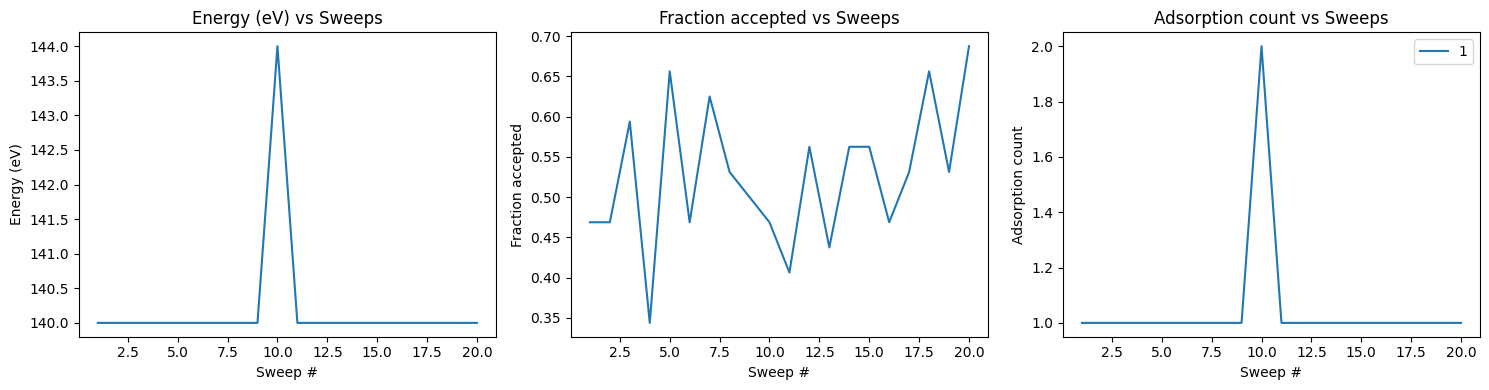

In [6]:
import copy

run_slab = copy.deepcopy(slab_batch)

mcmc = MCMC(
    calc=nff_calc,
    canonical=False,
    testing=False,
    surface_name=surface_name,
    element=element,
    adsorbates=adsorbates,
    ads_coords=ads_positions,
    relax=relax,
    offset=offset,
    offset_data=offset_data,
    relax_steps=relax_steps,
    optimizer=optimizer,
)

start = perf_counter()
# call the main function
mcmc.mcmc_run(
    total_sweeps=num_sweeps,
    sweep_size=sweep_size,
    start_temp=temp,
    pot=chem_pot, alpha=alpha, slab=run_slab
)

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [7]:
"""structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)"""

FileNotFoundError: [Errno 2] No such file or directory: 'data/SrTiO3_001_2x2_mcmc_structures.pkl'

In [ ]:
slab_batch.append('C')
slab_batch.positions[-1] = [5,5,6]
slab_batch.append('O')
slab_batch.positions[-1] = [6,6,5]

In [ ]:
slab_batch

AtomsBatch(symbols='Cu16COCO', pbc=True, cell=[5.105310960166873, 5.105310960166873, 15.415], constraint=FixAtoms(indices=[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]), calculator=EnsembleNFF(...))

In [ ]:
slab_batch.positions

array([[ 1.27632774,  1.27632774,  0.        ],
       [ 0.        ,  0.        ,  1.805     ],
       [ 1.27632774,  1.27632774,  3.61      ],
       [ 0.        ,  0.        ,  5.415     ],
       [ 1.27632774,  3.82898322,  0.        ],
       [ 0.        ,  2.55265548,  1.805     ],
       [ 0.        ,  2.55265548,  5.415     ],
       [ 2.55265548,  2.55265548,  5.415     ],
       [ 6.        ,  8.        , 10.        ],
       [ 6.        ,  8.        , 10.        ]])

In [ ]:
slab_batch

AtomsBatch(symbols='Cu8O2', pbc=True, cell=[5.105310960166873, 5.105310960166873, 15.415], constraint=FixAtoms(indices=[0, 1, 2, 4, 5]), calculator=EnsembleNFF(...))

In [ ]:
del slab_batch[]

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
slab_batch.positions

array([[ 1.27632774,  1.27632774,  0.        ],
       [ 0.        ,  0.        ,  1.805     ],
       [ 1.27632774,  1.27632774,  3.61      ],
       [ 0.        ,  0.        ,  5.415     ],
       [ 1.27632774,  3.82898322,  0.        ],
       [ 0.        ,  2.55265548,  1.805     ],
       [ 0.        ,  2.55265548,  5.415     ],
       [ 2.55265548,  2.55265548,  5.415     ],
       [ 6.        ,  8.        , 10.        ]])

In [ ]:
len(slab_batch)

16

In [ ]:
slab_batch.symbols

Symbols('Cu16')

In [ ]:
slab_batch[state[1]]

NameError: name 'state' is not defined